In [1]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from common.layers import NoisyLinear
from common.replay_buffer import ReplayBuffer
import gym_Aircraft

from itertools import count
import time
import itertools
import matplotlib
import matplotlib.pyplot as plt

In [2]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

In [3]:
env_id = "acav-v0"
env = gym.make(env_id)

/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
class RainbowDQN(nn.Module):
    def __init__(self, num_inputs, num_actions, num_atoms, Vmin, Vmax):
        super(RainbowDQN, self).__init__()
        
        self.num_inputs   = num_inputs
        self.num_actions  = num_actions
        self.num_atoms    = num_atoms
        self.Vmin         = Vmin
        self.Vmax         = Vmax
        
        self.linear1 = nn.Linear(num_inputs, 32)
        self.linear2 = nn.Linear(32, 64)
        
        self.noisy_value1 = NoisyLinear(64, 64, use_cuda=USE_CUDA)
        self.noisy_value2 = NoisyLinear(64, self.num_atoms, use_cuda=USE_CUDA)
        
        self.noisy_advantage1 = NoisyLinear(64, 64, use_cuda=USE_CUDA)
        self.noisy_advantage2 = NoisyLinear(64, self.num_atoms * self.num_actions, use_cuda=USE_CUDA)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        
        value = F.relu(self.noisy_value1(x))
        value = self.noisy_value2(value)
        
        advantage = F.relu(self.noisy_advantage1(x))
        advantage = self.noisy_advantage2(advantage)
        
        value     = value.view(batch_size, 1, self.num_atoms)
        advantage = advantage.view(batch_size, self.num_actions, self.num_atoms)
        
        x = value + advantage - advantage.mean(1, keepdim=True)
        x = F.softmax(x.view(-1, self.num_atoms)).view(-1, self.num_actions, self.num_atoms)
        
        return x
        
    def reset_noise(self):
        self.noisy_value1.reset_noise()
        self.noisy_value2.reset_noise()
        self.noisy_advantage1.reset_noise()
        self.noisy_advantage2.reset_noise()
    
    def act(self, state):
        state = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
        dist = self.forward(state).data.cpu()
        dist = dist * torch.linspace(self.Vmin, self.Vmax, self.num_atoms)
        action = dist.sum(2).max(1)[1].numpy()[0]
        return action

In [5]:
num_atoms = 51
Vmin = -10
Vmax = 10

current_model = RainbowDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)
target_model  = RainbowDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters(), 0.001)

replay_buffer = ReplayBuffer(10000)

In [6]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())
    
update_target(current_model, target_model)

In [7]:
def projection_distribution(next_state, rewards, dones):
    batch_size  = next_state.size(0)
    
    delta_z = float(Vmax - Vmin) / (num_atoms - 1)
    support = torch.linspace(Vmin, Vmax, num_atoms)
    
    next_dist   = target_model(next_state).data.cpu() * support
    next_action = next_dist.sum(2).max(1)[1]
    next_action = next_action.unsqueeze(1).unsqueeze(1).expand(next_dist.size(0), 1, next_dist.size(2))
    next_dist   = next_dist.gather(1, next_action).squeeze(1)
        
    rewards = rewards.unsqueeze(1).expand_as(next_dist)
    dones   = dones.unsqueeze(1).expand_as(next_dist)
    support = support.unsqueeze(0).expand_as(next_dist)
    
    Tz = rewards + (1 - dones) * 0.99 * support
    Tz = Tz.clamp(min=Vmin, max=Vmax)
    b  = (Tz - Vmin) / delta_z
    l  = b.floor().long()
    u  = b.ceil().long()
        
    offset = torch.linspace(0, (batch_size - 1) * num_atoms, batch_size).long()\
                    .unsqueeze(1).expand(batch_size, num_atoms)

    proj_dist = torch.zeros(next_dist.size())    
    proj_dist.view(-1).index_add_(0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1))
    proj_dist.view(-1).index_add_(0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1))
        
    return proj_dist

In [8]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size) 

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = torch.FloatTensor(reward)
    done       = torch.FloatTensor(np.float32(done))

    proj_dist = projection_distribution(next_state, reward, done)
    
    dist = current_model(state)
    action = action.unsqueeze(1).unsqueeze(1).expand(batch_size, 1, num_atoms)
    dist = dist.gather(1, action).squeeze(1)
    dist.data.clamp_(0.01, 0.99)
    loss = -(Variable(proj_dist) * dist.log()).sum(1)
    loss  = loss.mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    current_model.reset_noise()
    target_model.reset_noise()
    
    return loss

In [9]:
num_episodes = 10000
batch_size = 32
gamma=0.99
TARGET_UPDATE=10

losses = []
total_res=[]
reward_list=[]
for i_episode in range(num_episodes):
    total_reward=0
    
    # 환경과 상태 초기화
    res_list=np.zeros(11)
    state = env.reset()

    for t in count():
        # 행동 선택과 수행
        
        action = current_model.act(state)
        
        next_state, reward, done, res = env.step(action)
        
        # 메모리에 변이 저장
        replay_buffer.push(state, action, reward, next_state, done)
        

        # 새로운 상태 관찰
        if not done:
            next_state = next_state
        else:
            next_state = None

        

        # 다음 상태로 이동
        state = next_state

     
        # Data save
        
        cmd_list,r_list,elev_list,azim_list,Pm_list,Pt_list,h_list=res
        Pm_list=Pm_list.tolist()
        Pt_list=Pt_list.tolist()
        merged_data=itertools.chain([cmd_list],[r_list],[elev_list],[azim_list],Pm_list,Pt_list,[h_list])
        merged_data=np.array(list(merged_data))
        res_list=np.vstack([res_list,merged_data])
        
        total_reward+=reward
        
        if done:
            res_list=np.delete(res_list,0,0)
            
            total_res.append(res_list)
            reward_list.append(total_reward)
            
            now = time.localtime()
            print ("%04d/%02d/%02d %02d:%02d:%02d" % (now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min, now.tm_sec))
            print("episode : {} | final step : {} | total reward : {}".format(i_episode, t, total_reward))
            break
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(batch_size)
            losses.append(loss.item())
            
        
    #목표 네트워크 업데이트, 모든 웨이트와 바이어스 복사
    if i_episode % TARGET_UPDATE == 0:
        update_target(current_model, target_model)

print('Complete')
env.close()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


2020/10/04 11:33:59
episode : 0 | final step : 98 | total reward : -69.0
2020/10/04 11:34:00
episode : 1 | final step : 98 | total reward : -57.0
2020/10/04 11:34:01
episode : 2 | final step : 100 | total reward : 4.245636532174743
2020/10/04 11:34:02
episode : 3 | final step : 99 | total reward : -17.78547777184798
2020/10/04 11:34:04
episode : 4 | final step : 100 | total reward : -23.997627528771275
2020/10/04 11:34:05
episode : 5 | final step : 96 | total reward : -17.94884468665579
2020/10/04 11:34:06
episode : 6 | final step : 100 | total reward : -23.926731566602726
2020/10/04 11:34:07
episode : 7 | final step : 99 | total reward : -18.289974290047056
2020/10/04 11:34:08
episode : 8 | final step : 97 | total reward : -15.505111413592047
2020/10/04 11:34:09
episode : 9 | final step : 100 | total reward : -26.53335268696459
2020/10/04 11:34:10
episode : 10 | final step : 100 | total reward : -21.922927197679286
2020/10/04 11:34:11
episode : 11 | final step : 100 | total reward : -

2020/10/04 11:35:56
episode : 103 | final step : 95 | total reward : 80.86993165602861
2020/10/04 11:35:57
episode : 104 | final step : 98 | total reward : -50.0
2020/10/04 11:35:58
episode : 105 | final step : 100 | total reward : -50.0
2020/10/04 11:35:59
episode : 106 | final step : 99 | total reward : -50.0
2020/10/04 11:36:00
episode : 107 | final step : 98 | total reward : -50.0
2020/10/04 11:36:01
episode : 108 | final step : 98 | total reward : -50.0
2020/10/04 11:36:02
episode : 109 | final step : 98 | total reward : -50.0
2020/10/04 11:36:03
episode : 110 | final step : 98 | total reward : -50.0
2020/10/04 11:36:04
episode : 111 | final step : 99 | total reward : -50.0
2020/10/04 11:36:06
episode : 112 | final step : 99 | total reward : -50.0
2020/10/04 11:36:07
episode : 113 | final step : 100 | total reward : 98.37637173939464
2020/10/04 11:36:08
episode : 114 | final step : 99 | total reward : -50.0
2020/10/04 11:36:09
episode : 115 | final step : 98 | total reward : -50.0

2020/10/04 11:37:49
episode : 207 | final step : 98 | total reward : 96.5085538081456
2020/10/04 11:37:50
episode : 208 | final step : 97 | total reward : 85.30191233285959
2020/10/04 11:37:51
episode : 209 | final step : 97 | total reward : 96.70795375695349
2020/10/04 11:37:52
episode : 210 | final step : 98 | total reward : -50.0
2020/10/04 11:37:53
episode : 211 | final step : 98 | total reward : 98.96493384784111
2020/10/04 11:37:54
episode : 212 | final step : 98 | total reward : -50.0
2020/10/04 11:37:56
episode : 213 | final step : 98 | total reward : -50.0
2020/10/04 11:37:57
episode : 214 | final step : 98 | total reward : -50.0
2020/10/04 11:37:58
episode : 215 | final step : 99 | total reward : 97.36042691430899
2020/10/04 11:37:59
episode : 216 | final step : 99 | total reward : -50.0
2020/10/04 11:38:00
episode : 217 | final step : 98 | total reward : -50.0
2020/10/04 11:38:02
episode : 218 | final step : 98 | total reward : -50.0
2020/10/04 11:38:03
episode : 219 | final

2020/10/04 11:39:43
episode : 311 | final step : 98 | total reward : -50.0
2020/10/04 11:39:44
episode : 312 | final step : 98 | total reward : -50.0
2020/10/04 11:39:45
episode : 313 | final step : 99 | total reward : -50.0
2020/10/04 11:39:46
episode : 314 | final step : 99 | total reward : 99.7883215640335
2020/10/04 11:39:47
episode : 315 | final step : 99 | total reward : -50.0
2020/10/04 11:39:49
episode : 316 | final step : 97 | total reward : 88.48383405361808
2020/10/04 11:39:50
episode : 317 | final step : 98 | total reward : 98.80731276250184
2020/10/04 11:39:51
episode : 318 | final step : 98 | total reward : -50.0
2020/10/04 11:39:52
episode : 319 | final step : 98 | total reward : -50.0
2020/10/04 11:39:53
episode : 320 | final step : 100 | total reward : 94.90312793503608
2020/10/04 11:39:54
episode : 321 | final step : 99 | total reward : -50.0
2020/10/04 11:39:55
episode : 322 | final step : 98 | total reward : 99.93642820339176
2020/10/04 11:39:56
episode : 323 | fina

2020/10/04 11:41:36
episode : 415 | final step : 98 | total reward : -50.0
2020/10/04 11:41:38
episode : 416 | final step : 102 | total reward : 97.02684349815091
2020/10/04 11:41:39
episode : 417 | final step : 98 | total reward : -50.0
2020/10/04 11:41:40
episode : 418 | final step : 98 | total reward : -50.0
2020/10/04 11:41:41
episode : 419 | final step : 98 | total reward : -50.0
2020/10/04 11:41:42
episode : 420 | final step : 98 | total reward : -50.0
2020/10/04 11:41:43
episode : 421 | final step : 101 | total reward : 98.78931816674215
2020/10/04 11:41:44
episode : 422 | final step : 100 | total reward : -50.0
2020/10/04 11:41:45
episode : 423 | final step : 97 | total reward : 94.413346347853
2020/10/04 11:41:46
episode : 424 | final step : 100 | total reward : 94.09518413729906
2020/10/04 11:41:47
episode : 425 | final step : 97 | total reward : -50.0
2020/10/04 11:41:49
episode : 426 | final step : 100 | total reward : 99.9924208115668
2020/10/04 11:41:50
episode : 427 | fi

2020/10/04 11:43:30
episode : 520 | final step : 98 | total reward : -50.0
2020/10/04 11:43:31
episode : 521 | final step : 98 | total reward : -50.0
2020/10/04 11:43:32
episode : 522 | final step : 98 | total reward : -50.0
2020/10/04 11:43:34
episode : 523 | final step : 98 | total reward : 96.65109102417723
2020/10/04 11:43:35
episode : 524 | final step : 99 | total reward : -50.0
2020/10/04 11:43:36
episode : 525 | final step : 97 | total reward : 92.68872945796542
2020/10/04 11:43:37
episode : 526 | final step : 97 | total reward : 98.12708420722203
2020/10/04 11:43:39
episode : 527 | final step : 97 | total reward : 96.81877818133704
2020/10/04 11:43:39
episode : 528 | final step : 102 | total reward : 89.92428593335944
2020/10/04 11:43:40
episode : 529 | final step : 98 | total reward : -50.0
2020/10/04 11:43:41
episode : 530 | final step : 98 | total reward : -50.0
2020/10/04 11:43:42
episode : 531 | final step : 98 | total reward : -50.0
2020/10/04 11:43:43
episode : 532 | fin

2020/10/04 11:45:22
episode : 624 | final step : 99 | total reward : -50.0
2020/10/04 11:45:23
episode : 625 | final step : 98 | total reward : -50.0
2020/10/04 11:45:24
episode : 626 | final step : 99 | total reward : 99.62323124403946
2020/10/04 11:45:25
episode : 627 | final step : 98 | total reward : -50.0
2020/10/04 11:45:26
episode : 628 | final step : 99 | total reward : -50.0
2020/10/04 11:45:27
episode : 629 | final step : 98 | total reward : -50.0
2020/10/04 11:45:29
episode : 630 | final step : 98 | total reward : 98.87632406484977
2020/10/04 11:45:30
episode : 631 | final step : 100 | total reward : -50.0
2020/10/04 11:45:31
episode : 632 | final step : 98 | total reward : -50.0
2020/10/04 11:45:32
episode : 633 | final step : 98 | total reward : -50.0
2020/10/04 11:45:33
episode : 634 | final step : 101 | total reward : 98.83071345750058
2020/10/04 11:45:34
episode : 635 | final step : 98 | total reward : 99.82970240178459
2020/10/04 11:45:35
episode : 636 | final step : 9

2020/10/04 11:47:15
episode : 728 | final step : 98 | total reward : -50.0
2020/10/04 11:47:16
episode : 729 | final step : 98 | total reward : 98.38988876597935
2020/10/04 11:47:17
episode : 730 | final step : 98 | total reward : -50.0
2020/10/04 11:47:19
episode : 731 | final step : 98 | total reward : -50.0
2020/10/04 11:47:20
episode : 732 | final step : 98 | total reward : 91.72644674809018
2020/10/04 11:47:21
episode : 733 | final step : 97 | total reward : 98.88786870152401
2020/10/04 11:47:22
episode : 734 | final step : 100 | total reward : 99.78486989171114
2020/10/04 11:47:23
episode : 735 | final step : 99 | total reward : -50.0
2020/10/04 11:47:24
episode : 736 | final step : 98 | total reward : -50.0
2020/10/04 11:47:25
episode : 737 | final step : 96 | total reward : 88.94085347370701
2020/10/04 11:47:26
episode : 738 | final step : 99 | total reward : -50.0
2020/10/04 11:47:27
episode : 739 | final step : 99 | total reward : -50.0
2020/10/04 11:47:28
episode : 740 | fin

2020/10/04 11:49:07
episode : 831 | final step : 98 | total reward : -50.0
2020/10/04 11:49:08
episode : 832 | final step : 98 | total reward : -50.0
2020/10/04 11:49:09
episode : 833 | final step : 98 | total reward : -50.0
2020/10/04 11:49:10
episode : 834 | final step : 99 | total reward : -50.0
2020/10/04 11:49:11
episode : 835 | final step : 98 | total reward : -50.0
2020/10/04 11:49:12
episode : 836 | final step : 98 | total reward : -50.0
2020/10/04 11:49:13
episode : 837 | final step : 98 | total reward : -50.0
2020/10/04 11:49:14
episode : 838 | final step : 99 | total reward : -50.0
2020/10/04 11:49:15
episode : 839 | final step : 102 | total reward : 87.0339751359933
2020/10/04 11:49:16
episode : 840 | final step : 98 | total reward : -50.0
2020/10/04 11:49:17
episode : 841 | final step : 98 | total reward : -50.0
2020/10/04 11:49:18
episode : 842 | final step : 98 | total reward : -50.0
2020/10/04 11:49:19
episode : 843 | final step : 98 | total reward : -50.0
2020/10/04 11

2020/10/04 11:51:02
episode : 936 | final step : 100 | total reward : -50.0
2020/10/04 11:51:03
episode : 937 | final step : 99 | total reward : -50.0
2020/10/04 11:51:04
episode : 938 | final step : 99 | total reward : -50.0
2020/10/04 11:51:05
episode : 939 | final step : 98 | total reward : -50.0
2020/10/04 11:51:07
episode : 940 | final step : 101 | total reward : 92.29105688770171
2020/10/04 11:51:08
episode : 941 | final step : 98 | total reward : -50.0
2020/10/04 11:51:09
episode : 942 | final step : 98 | total reward : -50.0
2020/10/04 11:51:10
episode : 943 | final step : 98 | total reward : -50.0
2020/10/04 11:51:11
episode : 944 | final step : 99 | total reward : -50.0
2020/10/04 11:51:12
episode : 945 | final step : 99 | total reward : -50.0
2020/10/04 11:51:13
episode : 946 | final step : 98 | total reward : -50.0
2020/10/04 11:51:15
episode : 947 | final step : 98 | total reward : -50.0
2020/10/04 11:51:16
episode : 948 | final step : 98 | total reward : 85.93173160498979

2020/10/04 11:52:54
episode : 1039 | final step : 100 | total reward : 94.81124938060424
2020/10/04 11:52:55
episode : 1040 | final step : 98 | total reward : -50.0
2020/10/04 11:52:56
episode : 1041 | final step : 98 | total reward : -50.0
2020/10/04 11:52:57
episode : 1042 | final step : 99 | total reward : 98.85893152764957
2020/10/04 11:52:58
episode : 1043 | final step : 98 | total reward : -50.0
2020/10/04 11:52:59
episode : 1044 | final step : 100 | total reward : -50.0
2020/10/04 11:53:00
episode : 1045 | final step : 98 | total reward : -50.0
2020/10/04 11:53:01
episode : 1046 | final step : 95 | total reward : 81.99994169414569
2020/10/04 11:53:02
episode : 1047 | final step : 98 | total reward : -50.0
2020/10/04 11:53:03
episode : 1048 | final step : 99 | total reward : -50.0
2020/10/04 11:53:04
episode : 1049 | final step : 98 | total reward : -50.0
2020/10/04 11:53:05
episode : 1050 | final step : 100 | total reward : -50.0
2020/10/04 11:53:06
episode : 1051 | final step :

2020/10/04 11:54:46
episode : 1142 | final step : 98 | total reward : -50.0
2020/10/04 11:54:47
episode : 1143 | final step : 98 | total reward : -50.0
2020/10/04 11:54:49
episode : 1144 | final step : 102 | total reward : 93.7084411984673
2020/10/04 11:54:50
episode : 1145 | final step : 98 | total reward : -50.0
2020/10/04 11:54:51
episode : 1146 | final step : 98 | total reward : -50.0
2020/10/04 11:54:52
episode : 1147 | final step : 98 | total reward : -50.0
2020/10/04 11:54:54
episode : 1148 | final step : 98 | total reward : -50.0
2020/10/04 11:54:55
episode : 1149 | final step : 97 | total reward : -50.0
2020/10/04 11:54:56
episode : 1150 | final step : 97 | total reward : 94.04459993086692
2020/10/04 11:54:57
episode : 1151 | final step : 98 | total reward : 99.82321358091937
2020/10/04 11:54:58
episode : 1152 | final step : 96 | total reward : 90.33105765670216
2020/10/04 11:54:59
episode : 1153 | final step : 98 | total reward : 97.50926155032165
2020/10/04 11:55:00
episode 

2020/10/04 11:56:40
episode : 1245 | final step : 98 | total reward : -50.0
2020/10/04 11:56:42
episode : 1246 | final step : 100 | total reward : 98.72419096563247
2020/10/04 11:56:43
episode : 1247 | final step : 98 | total reward : -50.0
2020/10/04 11:56:44
episode : 1248 | final step : 101 | total reward : 98.68929915976933
2020/10/04 11:56:45
episode : 1249 | final step : 99 | total reward : -50.0
2020/10/04 11:56:46
episode : 1250 | final step : 98 | total reward : -50.0
2020/10/04 11:56:48
episode : 1251 | final step : 100 | total reward : 97.51743110161058
2020/10/04 11:56:49
episode : 1252 | final step : 98 | total reward : -50.0
2020/10/04 11:56:50
episode : 1253 | final step : 98 | total reward : -50.0
2020/10/04 11:56:51
episode : 1254 | final step : 96 | total reward : 81.35480765848311
2020/10/04 11:56:52
episode : 1255 | final step : 98 | total reward : -50.0
2020/10/04 11:56:53
episode : 1256 | final step : 103 | total reward : 88.3557925409311
2020/10/04 11:56:54
episo

2020/10/04 11:58:31
episode : 1348 | final step : 101 | total reward : 98.07185315488262
2020/10/04 11:58:32
episode : 1349 | final step : 101 | total reward : 97.47545678548371
2020/10/04 11:58:33
episode : 1350 | final step : 102 | total reward : 98.11611913253714
2020/10/04 11:58:34
episode : 1351 | final step : 99 | total reward : -50.0
2020/10/04 11:58:35
episode : 1352 | final step : 98 | total reward : -50.0
2020/10/04 11:58:36
episode : 1353 | final step : 99 | total reward : -50.0
2020/10/04 11:58:37
episode : 1354 | final step : 98 | total reward : -50.0
2020/10/04 11:58:38
episode : 1355 | final step : 99 | total reward : -50.0
2020/10/04 11:58:39
episode : 1356 | final step : 99 | total reward : -50.0
2020/10/04 11:58:40
episode : 1357 | final step : 98 | total reward : -50.0
2020/10/04 11:58:41
episode : 1358 | final step : 98 | total reward : -50.0
2020/10/04 11:58:42
episode : 1359 | final step : 99 | total reward : -50.0
2020/10/04 11:58:43
episode : 1360 | final step :

2020/10/04 12:00:19
episode : 1450 | final step : 99 | total reward : 98.22250785260445
2020/10/04 12:00:20
episode : 1451 | final step : 98 | total reward : 98.53599732839166
2020/10/04 12:00:21
episode : 1452 | final step : 100 | total reward : -50.0
2020/10/04 12:00:22
episode : 1453 | final step : 98 | total reward : -50.0
2020/10/04 12:00:23
episode : 1454 | final step : 99 | total reward : 98.65154020674093
2020/10/04 12:00:24
episode : 1455 | final step : 99 | total reward : 99.36166571106831
2020/10/04 12:00:25
episode : 1456 | final step : 99 | total reward : -50.0
2020/10/04 12:00:26
episode : 1457 | final step : 99 | total reward : 98.0055643117888
2020/10/04 12:00:27
episode : 1458 | final step : 99 | total reward : 99.95125421572187
2020/10/04 12:00:28
episode : 1459 | final step : 97 | total reward : 96.46854659842246
2020/10/04 12:00:29
episode : 1460 | final step : 98 | total reward : -50.0
2020/10/04 12:00:30
episode : 1461 | final step : 98 | total reward : -50.0
2020

2020/10/04 12:02:19
episode : 1553 | final step : 99 | total reward : -50.0
2020/10/04 12:02:20
episode : 1554 | final step : 99 | total reward : 93.77764504244679
2020/10/04 12:02:21
episode : 1555 | final step : 98 | total reward : -50.0
2020/10/04 12:02:22
episode : 1556 | final step : 98 | total reward : -50.0
2020/10/04 12:02:23
episode : 1557 | final step : 99 | total reward : 96.11863567838104
2020/10/04 12:02:24
episode : 1558 | final step : 98 | total reward : -50.0
2020/10/04 12:02:25
episode : 1559 | final step : 98 | total reward : -50.0
2020/10/04 12:02:26
episode : 1560 | final step : 99 | total reward : -50.0
2020/10/04 12:02:27
episode : 1561 | final step : 98 | total reward : -50.0
2020/10/04 12:02:28
episode : 1562 | final step : 99 | total reward : 90.67276036243696
2020/10/04 12:02:30
episode : 1563 | final step : 98 | total reward : -50.0
2020/10/04 12:02:31
episode : 1564 | final step : 99 | total reward : 95.89485977175868
2020/10/04 12:02:32
episode : 1565 | fin

2020/10/04 12:04:15
episode : 1655 | final step : 98 | total reward : -50.0
2020/10/04 12:04:16
episode : 1656 | final step : 98 | total reward : -50.0
2020/10/04 12:04:17
episode : 1657 | final step : 98 | total reward : -50.0
2020/10/04 12:04:18
episode : 1658 | final step : 99 | total reward : -50.0
2020/10/04 12:04:19
episode : 1659 | final step : 98 | total reward : -50.0
2020/10/04 12:04:20
episode : 1660 | final step : 99 | total reward : 88.74549623534182
2020/10/04 12:04:21
episode : 1661 | final step : 98 | total reward : -50.0
2020/10/04 12:04:22
episode : 1662 | final step : 96 | total reward : 92.03751246610004
2020/10/04 12:04:23
episode : 1663 | final step : 98 | total reward : -50.0
2020/10/04 12:04:25
episode : 1664 | final step : 100 | total reward : 96.94523387059213
2020/10/04 12:04:26
episode : 1665 | final step : 98 | total reward : -50.0
2020/10/04 12:04:27
episode : 1666 | final step : 98 | total reward : -50.0
2020/10/04 12:04:28
episode : 1667 | final step : 9

2020/10/04 12:06:14
episode : 1758 | final step : 98 | total reward : -50.0
2020/10/04 12:06:15
episode : 1759 | final step : 99 | total reward : -50.0
2020/10/04 12:06:16
episode : 1760 | final step : 97 | total reward : 99.19606748960142
2020/10/04 12:06:17
episode : 1761 | final step : 99 | total reward : -50.0
2020/10/04 12:06:18
episode : 1762 | final step : 100 | total reward : -50.0
2020/10/04 12:06:19
episode : 1763 | final step : 99 | total reward : 89.20726528515736
2020/10/04 12:06:21
episode : 1764 | final step : 100 | total reward : -50.0
2020/10/04 12:06:22
episode : 1765 | final step : 99 | total reward : -50.0
2020/10/04 12:06:23
episode : 1766 | final step : 100 | total reward : 99.20882218217753
2020/10/04 12:06:24
episode : 1767 | final step : 98 | total reward : -50.0
2020/10/04 12:06:26
episode : 1768 | final step : 99 | total reward : 85.88559373441075
2020/10/04 12:06:27
episode : 1769 | final step : 100 | total reward : 99.99998999930341
2020/10/04 12:06:28
epis

2020/10/04 12:08:12
episode : 1861 | final step : 100 | total reward : -50.0
2020/10/04 12:08:13
episode : 1862 | final step : 99 | total reward : 87.64559386384124
2020/10/04 12:08:14
episode : 1863 | final step : 99 | total reward : -50.0
2020/10/04 12:08:15
episode : 1864 | final step : 97 | total reward : -50.0
2020/10/04 12:08:16
episode : 1865 | final step : 98 | total reward : -50.0
2020/10/04 12:08:17
episode : 1866 | final step : 99 | total reward : 96.15146081403596
2020/10/04 12:08:18
episode : 1867 | final step : 98 | total reward : -50.0
2020/10/04 12:08:20
episode : 1868 | final step : 99 | total reward : -50.0
2020/10/04 12:08:21
episode : 1869 | final step : 98 | total reward : -50.0
2020/10/04 12:08:22
episode : 1870 | final step : 99 | total reward : -50.0
2020/10/04 12:08:23
episode : 1871 | final step : 99 | total reward : -50.0
2020/10/04 12:08:24
episode : 1872 | final step : 98 | total reward : -50.0
2020/10/04 12:08:25
episode : 1873 | final step : 98 | total re

2020/10/04 12:10:11
episode : 1964 | final step : 98 | total reward : -50.0
2020/10/04 12:10:12
episode : 1965 | final step : 99 | total reward : -50.0
2020/10/04 12:10:14
episode : 1966 | final step : 100 | total reward : -50.0
2020/10/04 12:10:15
episode : 1967 | final step : 98 | total reward : -50.0
2020/10/04 12:10:16
episode : 1968 | final step : 98 | total reward : 99.49823612036127
2020/10/04 12:10:17
episode : 1969 | final step : 98 | total reward : -50.0
2020/10/04 12:10:18
episode : 1970 | final step : 97 | total reward : 90.02130038555163
2020/10/04 12:10:19
episode : 1971 | final step : 99 | total reward : -50.0
2020/10/04 12:10:20
episode : 1972 | final step : 98 | total reward : -50.0
2020/10/04 12:10:21
episode : 1973 | final step : 99 | total reward : -50.0
2020/10/04 12:10:22
episode : 1974 | final step : 99 | total reward : -50.0
2020/10/04 12:10:23
episode : 1975 | final step : 100 | total reward : 99.91265985905574
2020/10/04 12:10:24
episode : 1976 | final step : 

2020/10/04 12:12:07
episode : 2067 | final step : 98 | total reward : -50.0
2020/10/04 12:12:08
episode : 2068 | final step : 97 | total reward : 98.87493386982858
2020/10/04 12:12:09
episode : 2069 | final step : 98 | total reward : -50.0
2020/10/04 12:12:10
episode : 2070 | final step : 99 | total reward : -50.0
2020/10/04 12:12:11
episode : 2071 | final step : 100 | total reward : 97.0515604885338
2020/10/04 12:12:12
episode : 2072 | final step : 99 | total reward : -50.0
2020/10/04 12:12:13
episode : 2073 | final step : 98 | total reward : -50.0
2020/10/04 12:12:14
episode : 2074 | final step : 98 | total reward : -50.0
2020/10/04 12:12:15
episode : 2075 | final step : 97 | total reward : 97.31999801607925
2020/10/04 12:12:16
episode : 2076 | final step : 98 | total reward : -50.0
2020/10/04 12:12:18
episode : 2077 | final step : 97 | total reward : 93.23281148559406
2020/10/04 12:12:19
episode : 2078 | final step : 98 | total reward : -50.0
2020/10/04 12:12:20
episode : 2079 | fin

2020/10/04 12:14:03
episode : 2170 | final step : 98 | total reward : -50.0
2020/10/04 12:14:04
episode : 2171 | final step : 101 | total reward : 93.47729004275702
2020/10/04 12:14:05
episode : 2172 | final step : 96 | total reward : 85.08889122584515
2020/10/04 12:14:06
episode : 2173 | final step : 98 | total reward : -50.0
2020/10/04 12:14:07
episode : 2174 | final step : 99 | total reward : -50.0
2020/10/04 12:14:08
episode : 2175 | final step : 99 | total reward : -50.0
2020/10/04 12:14:09
episode : 2176 | final step : 98 | total reward : -50.0
2020/10/04 12:14:11
episode : 2177 | final step : 98 | total reward : 99.78783159992291
2020/10/04 12:14:12
episode : 2178 | final step : 98 | total reward : -50.0
2020/10/04 12:14:13
episode : 2179 | final step : 98 | total reward : 99.05881605360963
2020/10/04 12:14:14
episode : 2180 | final step : 98 | total reward : -50.0
2020/10/04 12:14:15
episode : 2181 | final step : 98 | total reward : -50.0
2020/10/04 12:14:16
episode : 2182 | fi

2020/10/04 12:15:57
episode : 2272 | final step : 98 | total reward : -50.0
2020/10/04 12:15:59
episode : 2273 | final step : 98 | total reward : -50.0
2020/10/04 12:16:00
episode : 2274 | final step : 100 | total reward : 95.84944697752972
2020/10/04 12:16:01
episode : 2275 | final step : 98 | total reward : -50.0
2020/10/04 12:16:02
episode : 2276 | final step : 100 | total reward : 99.99691598296216
2020/10/04 12:16:03
episode : 2277 | final step : 99 | total reward : -50.0
2020/10/04 12:16:04
episode : 2278 | final step : 98 | total reward : -50.0
2020/10/04 12:16:05
episode : 2279 | final step : 99 | total reward : -50.0
2020/10/04 12:16:07
episode : 2280 | final step : 98 | total reward : -50.0
2020/10/04 12:16:08
episode : 2281 | final step : 97 | total reward : 83.84616492553457
2020/10/04 12:16:09
episode : 2282 | final step : 98 | total reward : -50.0
2020/10/04 12:16:10
episode : 2283 | final step : 97 | total reward : -50.0
2020/10/04 12:16:11
episode : 2284 | final step : 

2020/10/04 12:17:56
episode : 2375 | final step : 97 | total reward : 94.15971131341826
2020/10/04 12:17:57
episode : 2376 | final step : 102 | total reward : 95.75602788516058
2020/10/04 12:17:58
episode : 2377 | final step : 101 | total reward : 99.99407650559506
2020/10/04 12:17:59
episode : 2378 | final step : 97 | total reward : -50.0
2020/10/04 12:18:00
episode : 2379 | final step : 97 | total reward : 97.93612497031393
2020/10/04 12:18:01
episode : 2380 | final step : 100 | total reward : -50.0
2020/10/04 12:18:02
episode : 2381 | final step : 99 | total reward : -50.0
2020/10/04 12:18:03
episode : 2382 | final step : 98 | total reward : -50.0
2020/10/04 12:18:04
episode : 2383 | final step : 98 | total reward : -50.0
2020/10/04 12:18:05
episode : 2384 | final step : 98 | total reward : -50.0
2020/10/04 12:18:06
episode : 2385 | final step : 98 | total reward : -50.0
2020/10/04 12:18:07
episode : 2386 | final step : 98 | total reward : -50.0
2020/10/04 12:18:08
episode : 2387 | 

2020/10/04 12:19:52
episode : 2479 | final step : 99 | total reward : -50.0
2020/10/04 12:19:53
episode : 2480 | final step : 99 | total reward : -50.0
2020/10/04 12:19:55
episode : 2481 | final step : 97 | total reward : -50.0
2020/10/04 12:19:56
episode : 2482 | final step : 99 | total reward : 99.09596684962881
2020/10/04 12:19:57
episode : 2483 | final step : 100 | total reward : -50.0
2020/10/04 12:19:58
episode : 2484 | final step : 98 | total reward : 98.1434676406689
2020/10/04 12:19:59
episode : 2485 | final step : 98 | total reward : -50.0
2020/10/04 12:20:00
episode : 2486 | final step : 98 | total reward : -50.0
2020/10/04 12:20:01
episode : 2487 | final step : 97 | total reward : 96.69630074038544
2020/10/04 12:20:02
episode : 2488 | final step : 98 | total reward : -50.0
2020/10/04 12:20:03
episode : 2489 | final step : 100 | total reward : -50.0
2020/10/04 12:20:04
episode : 2490 | final step : 98 | total reward : -50.0
2020/10/04 12:20:05
episode : 2491 | final step : 1

2020/10/04 12:21:46
episode : 2582 | final step : 100 | total reward : -50.0
2020/10/04 12:21:47
episode : 2583 | final step : 99 | total reward : -50.0
2020/10/04 12:21:48
episode : 2584 | final step : 99 | total reward : -50.0
2020/10/04 12:21:49
episode : 2585 | final step : 98 | total reward : -50.0
2020/10/04 12:21:50
episode : 2586 | final step : 98 | total reward : 95.77170235513553
2020/10/04 12:21:51
episode : 2587 | final step : 99 | total reward : 93.28471593763881
2020/10/04 12:21:51
episode : 2588 | final step : 98 | total reward : -50.0
2020/10/04 12:21:52
episode : 2589 | final step : 98 | total reward : -50.0
2020/10/04 12:21:53
episode : 2590 | final step : 98 | total reward : -50.0
2020/10/04 12:21:54
episode : 2591 | final step : 99 | total reward : -50.0
2020/10/04 12:21:56
episode : 2592 | final step : 99 | total reward : -50.0
2020/10/04 12:21:57
episode : 2593 | final step : 100 | total reward : 99.59542914409072
2020/10/04 12:21:58
episode : 2594 | final step : 

2020/10/04 12:23:38
episode : 2686 | final step : 98 | total reward : -50.0
2020/10/04 12:23:39
episode : 2687 | final step : 99 | total reward : -50.0
2020/10/04 12:23:40
episode : 2688 | final step : 97 | total reward : 93.54623297562564
2020/10/04 12:23:41
episode : 2689 | final step : 100 | total reward : 99.58656782108498
2020/10/04 12:23:42
episode : 2690 | final step : 98 | total reward : -50.0
2020/10/04 12:23:43
episode : 2691 | final step : 99 | total reward : 99.84856151124704
2020/10/04 12:23:44
episode : 2692 | final step : 100 | total reward : -50.0
2020/10/04 12:23:45
episode : 2693 | final step : 98 | total reward : -50.0
2020/10/04 12:23:46
episode : 2694 | final step : 98 | total reward : -50.0
2020/10/04 12:23:47
episode : 2695 | final step : 98 | total reward : 99.02692538923921
2020/10/04 12:23:48
episode : 2696 | final step : 99 | total reward : -50.0
2020/10/04 12:23:49
episode : 2697 | final step : 98 | total reward : -50.0
2020/10/04 12:23:50
episode : 2698 | f

2020/10/04 12:25:28
episode : 2789 | final step : 98 | total reward : -50.0
2020/10/04 12:25:29
episode : 2790 | final step : 98 | total reward : -51.0
2020/10/04 12:25:30
episode : 2791 | final step : 98 | total reward : -50.0
2020/10/04 12:25:31
episode : 2792 | final step : 100 | total reward : 99.83689598244864
2020/10/04 12:25:33
episode : 2793 | final step : 99 | total reward : -50.0
2020/10/04 12:25:34
episode : 2794 | final step : 99 | total reward : 99.23859063608829
2020/10/04 12:25:35
episode : 2795 | final step : 100 | total reward : 97.8054720701723
2020/10/04 12:25:36
episode : 2796 | final step : 99 | total reward : -50.0
2020/10/04 12:25:37
episode : 2797 | final step : 99 | total reward : -50.0
2020/10/04 12:25:38
episode : 2798 | final step : 98 | total reward : 92.33806585151129
2020/10/04 12:25:38
episode : 2799 | final step : 96 | total reward : 90.55725129370072
2020/10/04 12:25:40
episode : 2800 | final step : 99 | total reward : -50.0
2020/10/04 12:25:41
episode

2020/10/04 12:27:23
episode : 2891 | final step : 98 | total reward : -50.0
2020/10/04 12:27:25
episode : 2892 | final step : 99 | total reward : 99.32983489173411
2020/10/04 12:27:26
episode : 2893 | final step : 97 | total reward : 97.21642286272926
2020/10/04 12:27:27
episode : 2894 | final step : 100 | total reward : 99.37653368168924
2020/10/04 12:27:28
episode : 2895 | final step : 98 | total reward : -50.0
2020/10/04 12:27:29
episode : 2896 | final step : 98 | total reward : 99.95948449774824
2020/10/04 12:27:31
episode : 2897 | final step : 100 | total reward : -50.0
2020/10/04 12:27:32
episode : 2898 | final step : 98 | total reward : -50.0
2020/10/04 12:27:33
episode : 2899 | final step : 99 | total reward : 99.38441323561241
2020/10/04 12:27:34
episode : 2900 | final step : 98 | total reward : -50.0
2020/10/04 12:27:35
episode : 2901 | final step : 103 | total reward : 95.51965253612983
2020/10/04 12:27:36
episode : 2902 | final step : 100 | total reward : 98.26148924163228


2020/10/04 12:29:23
episode : 2994 | final step : 99 | total reward : 98.95004073328032
2020/10/04 12:29:24
episode : 2995 | final step : 100 | total reward : 91.31788885807467
2020/10/04 12:29:25
episode : 2996 | final step : 98 | total reward : -50.0
2020/10/04 12:29:26
episode : 2997 | final step : 98 | total reward : -50.0
2020/10/04 12:29:27
episode : 2998 | final step : 97 | total reward : 83.31976244453456
2020/10/04 12:29:28
episode : 2999 | final step : 98 | total reward : -50.0
2020/10/04 12:29:29
episode : 3000 | final step : 98 | total reward : -50.0
2020/10/04 12:29:30
episode : 3001 | final step : 98 | total reward : -50.0
2020/10/04 12:29:31
episode : 3002 | final step : 98 | total reward : -50.0
2020/10/04 12:29:33
episode : 3003 | final step : 98 | total reward : -50.0
2020/10/04 12:29:34
episode : 3004 | final step : 98 | total reward : 99.44230413371645
2020/10/04 12:29:35
episode : 3005 | final step : 98 | total reward : -50.0
2020/10/04 12:29:36
episode : 3006 | fi

2020/10/04 12:31:19
episode : 3098 | final step : 99 | total reward : -50.0
2020/10/04 12:31:20
episode : 3099 | final step : 99 | total reward : -50.0
2020/10/04 12:31:21
episode : 3100 | final step : 99 | total reward : -50.0
2020/10/04 12:31:22
episode : 3101 | final step : 98 | total reward : -50.0
2020/10/04 12:31:23
episode : 3102 | final step : 100 | total reward : 99.79785038022652
2020/10/04 12:31:24
episode : 3103 | final step : 98 | total reward : -50.0
2020/10/04 12:31:25
episode : 3104 | final step : 99 | total reward : -50.0
2020/10/04 12:31:26
episode : 3105 | final step : 98 | total reward : -50.0
2020/10/04 12:31:27
episode : 3106 | final step : 98 | total reward : -50.0
2020/10/04 12:31:28
episode : 3107 | final step : 98 | total reward : -50.0
2020/10/04 12:31:29
episode : 3108 | final step : 99 | total reward : 95.70941877202347
2020/10/04 12:31:31
episode : 3109 | final step : 98 | total reward : 99.73181160627462
2020/10/04 12:31:32
episode : 3110 | final step : 9

2020/10/04 12:33:14
episode : 3202 | final step : 97 | total reward : 96.1389574402309
2020/10/04 12:33:15
episode : 3203 | final step : 98 | total reward : -50.0
2020/10/04 12:33:16
episode : 3204 | final step : 100 | total reward : -50.0
2020/10/04 12:33:17
episode : 3205 | final step : 99 | total reward : 97.6825095990944
2020/10/04 12:33:18
episode : 3206 | final step : 97 | total reward : -50.0
2020/10/04 12:33:19
episode : 3207 | final step : 96 | total reward : 87.498807712538
2020/10/04 12:33:21
episode : 3208 | final step : 98 | total reward : -50.0
2020/10/04 12:33:22
episode : 3209 | final step : 97 | total reward : -50.0
2020/10/04 12:33:23
episode : 3210 | final step : 97 | total reward : 99.62160573554004
2020/10/04 12:33:24
episode : 3211 | final step : 98 | total reward : -50.0
2020/10/04 12:33:25
episode : 3212 | final step : 97 | total reward : 99.42308662399905
2020/10/04 12:33:26
episode : 3213 | final step : 98 | total reward : -50.0
2020/10/04 12:33:27
episode : 3

2020/10/04 12:35:09
episode : 3305 | final step : 98 | total reward : -50.0
2020/10/04 12:35:10
episode : 3306 | final step : 98 | total reward : -50.0
2020/10/04 12:35:11
episode : 3307 | final step : 99 | total reward : 94.25405933514755
2020/10/04 12:35:12
episode : 3308 | final step : 99 | total reward : 95.4429372057107
2020/10/04 12:35:13
episode : 3309 | final step : 98 | total reward : -50.0
2020/10/04 12:35:14
episode : 3310 | final step : 98 | total reward : 95.93324380394158
2020/10/04 12:35:15
episode : 3311 | final step : 98 | total reward : -50.0
2020/10/04 12:35:16
episode : 3312 | final step : 98 | total reward : -50.0
2020/10/04 12:35:17
episode : 3313 | final step : 98 | total reward : -50.0
2020/10/04 12:35:19
episode : 3314 | final step : 98 | total reward : -50.0
2020/10/04 12:35:20
episode : 3315 | final step : 96 | total reward : 85.24029002815523
2020/10/04 12:35:21
episode : 3316 | final step : 99 | total reward : -50.0
2020/10/04 12:35:22
episode : 3317 | fina

2020/10/04 12:37:03
episode : 3408 | final step : 98 | total reward : -50.0
2020/10/04 12:37:04
episode : 3409 | final step : 98 | total reward : -50.0
2020/10/04 12:37:05
episode : 3410 | final step : 98 | total reward : -50.0
2020/10/04 12:37:06
episode : 3411 | final step : 98 | total reward : -50.0
2020/10/04 12:37:07
episode : 3412 | final step : 99 | total reward : 99.241145808413
2020/10/04 12:37:08
episode : 3413 | final step : 98 | total reward : -50.0
2020/10/04 12:37:09
episode : 3414 | final step : 98 | total reward : -50.0
2020/10/04 12:37:10
episode : 3415 | final step : 98 | total reward : -50.0
2020/10/04 12:37:11
episode : 3416 | final step : 98 | total reward : -50.0
2020/10/04 12:37:12
episode : 3417 | final step : 101 | total reward : 97.07628261870651
2020/10/04 12:37:13
episode : 3418 | final step : 98 | total reward : -50.0
2020/10/04 12:37:14
episode : 3419 | final step : 99 | total reward : -50.0
2020/10/04 12:37:15
episode : 3420 | final step : 98 | total rewa

2020/10/04 12:38:53
episode : 3510 | final step : 99 | total reward : -50.0
2020/10/04 12:38:54
episode : 3511 | final step : 98 | total reward : -50.0
2020/10/04 12:38:55
episode : 3512 | final step : 99 | total reward : -50.0
2020/10/04 12:38:57
episode : 3513 | final step : 98 | total reward : -50.0
2020/10/04 12:38:57
episode : 3514 | final step : 98 | total reward : -50.0
2020/10/04 12:38:59
episode : 3515 | final step : 98 | total reward : -50.0
2020/10/04 12:39:00
episode : 3516 | final step : 99 | total reward : -50.0
2020/10/04 12:39:01
episode : 3517 | final step : 100 | total reward : 98.49064597270356
2020/10/04 12:39:02
episode : 3518 | final step : 98 | total reward : 97.98013118121396
2020/10/04 12:39:03
episode : 3519 | final step : 99 | total reward : -50.0
2020/10/04 12:39:04
episode : 3520 | final step : 98 | total reward : -50.0
2020/10/04 12:39:05
episode : 3521 | final step : 98 | total reward : -50.0
2020/10/04 12:39:06
episode : 3522 | final step : 98 | total re

2020/10/04 12:40:47
episode : 3614 | final step : 98 | total reward : -50.0
2020/10/04 12:40:48
episode : 3615 | final step : 98 | total reward : -50.0
2020/10/04 12:40:49
episode : 3616 | final step : 99 | total reward : -50.0
2020/10/04 12:40:50
episode : 3617 | final step : 100 | total reward : 99.99050016087158
2020/10/04 12:40:51
episode : 3618 | final step : 99 | total reward : -50.0
2020/10/04 12:40:53
episode : 3619 | final step : 99 | total reward : -50.0
2020/10/04 12:40:54
episode : 3620 | final step : 98 | total reward : -50.0
2020/10/04 12:40:55
episode : 3621 | final step : 99 | total reward : -50.0
2020/10/04 12:40:56
episode : 3622 | final step : 98 | total reward : -50.0
2020/10/04 12:40:57
episode : 3623 | final step : 98 | total reward : -50.0
2020/10/04 12:40:58
episode : 3624 | final step : 97 | total reward : 98.94116189453898
2020/10/04 12:40:59
episode : 3625 | final step : 98 | total reward : -50.0
2020/10/04 12:41:00
episode : 3626 | final step : 99 | total re

2020/10/04 12:42:40
episode : 3717 | final step : 97 | total reward : 99.42113751485553
2020/10/04 12:42:41
episode : 3718 | final step : 97 | total reward : -50.0
2020/10/04 12:42:43
episode : 3719 | final step : 98 | total reward : -50.0
2020/10/04 12:42:44
episode : 3720 | final step : 98 | total reward : -50.0
2020/10/04 12:42:45
episode : 3721 | final step : 98 | total reward : -50.0
2020/10/04 12:42:46
episode : 3722 | final step : 97 | total reward : 99.87071344294067
2020/10/04 12:42:47
episode : 3723 | final step : 98 | total reward : 99.95959113144059
2020/10/04 12:42:48
episode : 3724 | final step : 99 | total reward : -50.0
2020/10/04 12:42:49
episode : 3725 | final step : 98 | total reward : -50.0
2020/10/04 12:42:50
episode : 3726 | final step : 98 | total reward : -50.0
2020/10/04 12:42:51
episode : 3727 | final step : 98 | total reward : -50.0
2020/10/04 12:42:52
episode : 3728 | final step : 100 | total reward : 97.81382184461302
2020/10/04 12:42:53
episode : 3729 | fi

2020/10/04 12:44:36
episode : 3821 | final step : 99 | total reward : -50.0
2020/10/04 12:44:38
episode : 3822 | final step : 98 | total reward : -50.0
2020/10/04 12:44:39
episode : 3823 | final step : 97 | total reward : 95.72116191549189
2020/10/04 12:44:40
episode : 3824 | final step : 100 | total reward : 99.46155466665898
2020/10/04 12:44:41
episode : 3825 | final step : 98 | total reward : -50.0
2020/10/04 12:44:42
episode : 3826 | final step : 98 | total reward : -50.0
2020/10/04 12:44:44
episode : 3827 | final step : 100 | total reward : 97.86959154691758
2020/10/04 12:44:45
episode : 3828 | final step : 100 | total reward : 98.13338444086223
2020/10/04 12:44:47
episode : 3829 | final step : 99 | total reward : -50.0
2020/10/04 12:44:48
episode : 3830 | final step : 99 | total reward : 99.95483033760877
2020/10/04 12:44:49
episode : 3831 | final step : 98 | total reward : -50.0
2020/10/04 12:44:50
episode : 3832 | final step : 99 | total reward : -50.0
2020/10/04 12:44:51
episo

2020/10/04 12:46:33
episode : 3922 | final step : 98 | total reward : -50.0
2020/10/04 12:46:34
episode : 3923 | final step : 98 | total reward : -50.0
2020/10/04 12:46:35
episode : 3924 | final step : 98 | total reward : -50.0
2020/10/04 12:46:36
episode : 3925 | final step : 98 | total reward : -50.0
2020/10/04 12:46:37
episode : 3926 | final step : 98 | total reward : -50.0
2020/10/04 12:46:38
episode : 3927 | final step : 98 | total reward : -50.0
2020/10/04 12:46:40
episode : 3928 | final step : 98 | total reward : -50.0
2020/10/04 12:46:41
episode : 3929 | final step : 98 | total reward : 99.8943840957589
2020/10/04 12:46:42
episode : 3930 | final step : 99 | total reward : -50.0
2020/10/04 12:46:43
episode : 3931 | final step : 98 | total reward : -50.0
2020/10/04 12:46:44
episode : 3932 | final step : 98 | total reward : -50.0
2020/10/04 12:46:45
episode : 3933 | final step : 98 | total reward : -50.0
2020/10/04 12:46:46
episode : 3934 | final step : 98 | total reward : -50.0
2

2020/10/04 12:48:37
episode : 4026 | final step : 100 | total reward : 97.82482837788974
2020/10/04 12:48:38
episode : 4027 | final step : 97 | total reward : 99.27839515729546
2020/10/04 12:48:39
episode : 4028 | final step : 99 | total reward : 99.65159157935724
2020/10/04 12:48:40
episode : 4029 | final step : 98 | total reward : 92.74367484916746
2020/10/04 12:48:41
episode : 4030 | final step : 98 | total reward : -50.0
2020/10/04 12:48:43
episode : 4031 | final step : 98 | total reward : -50.0
2020/10/04 12:48:44
episode : 4032 | final step : 100 | total reward : 94.10360024455393
2020/10/04 12:48:45
episode : 4033 | final step : 97 | total reward : 89.3424364399324
2020/10/04 12:48:46
episode : 4034 | final step : 99 | total reward : -50.0
2020/10/04 12:48:47
episode : 4035 | final step : 98 | total reward : -50.0
2020/10/04 12:48:49
episode : 4036 | final step : 96 | total reward : 95.0440337465072
2020/10/04 12:48:50
episode : 4037 | final step : 99 | total reward : -50.0
2020

2020/10/04 12:50:35
episode : 4127 | final step : 100 | total reward : 90.66582279525183
2020/10/04 12:50:36
episode : 4128 | final step : 98 | total reward : -50.0
2020/10/04 12:50:37
episode : 4129 | final step : 98 | total reward : -50.0
2020/10/04 12:50:38
episode : 4130 | final step : 98 | total reward : -50.0
2020/10/04 12:50:40
episode : 4131 | final step : 99 | total reward : -50.0
2020/10/04 12:50:41
episode : 4132 | final step : 98 | total reward : -50.0
2020/10/04 12:50:42
episode : 4133 | final step : 98 | total reward : -50.0
2020/10/04 12:50:44
episode : 4134 | final step : 98 | total reward : -50.0
2020/10/04 12:50:45
episode : 4135 | final step : 99 | total reward : 99.9772976637172
2020/10/04 12:50:46
episode : 4136 | final step : 98 | total reward : 98.95675188452007
2020/10/04 12:50:47
episode : 4137 | final step : 100 | total reward : -50.0
2020/10/04 12:50:48
episode : 4138 | final step : 98 | total reward : -50.0
2020/10/04 12:50:49
episode : 4139 | final step : 9

2020/10/04 12:52:36
episode : 4229 | final step : 98 | total reward : 95.45907637131221
2020/10/04 12:52:38
episode : 4230 | final step : 99 | total reward : -50.0
2020/10/04 12:52:39
episode : 4231 | final step : 98 | total reward : -50.0
2020/10/04 12:52:40
episode : 4232 | final step : 98 | total reward : 96.18842434885885
2020/10/04 12:52:41
episode : 4233 | final step : 99 | total reward : -50.0
2020/10/04 12:52:42
episode : 4234 | final step : 98 | total reward : 94.25258899267874
2020/10/04 12:52:43
episode : 4235 | final step : 98 | total reward : -50.0
2020/10/04 12:52:44
episode : 4236 | final step : 99 | total reward : 99.77926639869541
2020/10/04 12:52:45
episode : 4237 | final step : 96 | total reward : 88.0824460814067
2020/10/04 12:52:46
episode : 4238 | final step : 98 | total reward : -50.0
2020/10/04 12:52:47
episode : 4239 | final step : 99 | total reward : -50.0
2020/10/04 12:52:49
episode : 4240 | final step : 98 | total reward : -50.0
2020/10/04 12:52:50
episode :

2020/10/04 12:54:33
episode : 4331 | final step : 96 | total reward : 90.36864752473642
2020/10/04 12:54:34
episode : 4332 | final step : 98 | total reward : -50.0
2020/10/04 12:54:35
episode : 4333 | final step : 100 | total reward : 99.84132855600821
2020/10/04 12:54:37
episode : 4334 | final step : 99 | total reward : -50.0
2020/10/04 12:54:38
episode : 4335 | final step : 96 | total reward : 91.40085708490072
2020/10/04 12:54:39
episode : 4336 | final step : 99 | total reward : 92.45848915687239
2020/10/04 12:54:40
episode : 4337 | final step : 98 | total reward : -50.0
2020/10/04 12:54:41
episode : 4338 | final step : 98 | total reward : -50.0
2020/10/04 12:54:42
episode : 4339 | final step : 98 | total reward : -50.0
2020/10/04 12:54:43
episode : 4340 | final step : 99 | total reward : -50.0
2020/10/04 12:54:45
episode : 4341 | final step : 99 | total reward : -50.0
2020/10/04 12:54:46
episode : 4342 | final step : 98 | total reward : -50.0
2020/10/04 12:54:47
episode : 4343 | fi

2020/10/04 12:56:33
episode : 4433 | final step : 100 | total reward : 99.99406963027738
2020/10/04 12:56:34
episode : 4434 | final step : 98 | total reward : 97.83916202310826
2020/10/04 12:56:35
episode : 4435 | final step : 98 | total reward : -50.0
2020/10/04 12:56:37
episode : 4436 | final step : 99 | total reward : -50.0
2020/10/04 12:56:38
episode : 4437 | final step : 98 | total reward : -50.0
2020/10/04 12:56:39
episode : 4438 | final step : 99 | total reward : -50.0
2020/10/04 12:56:40
episode : 4439 | final step : 98 | total reward : -50.0
2020/10/04 12:56:41
episode : 4440 | final step : 96 | total reward : 85.88201277048563
2020/10/04 12:56:42
episode : 4441 | final step : 98 | total reward : -50.0
2020/10/04 12:56:43
episode : 4442 | final step : 98 | total reward : -50.0
2020/10/04 12:56:44
episode : 4443 | final step : 95 | total reward : 80.57767509539966
2020/10/04 12:56:45
episode : 4444 | final step : 96 | total reward : 87.4397440141245
2020/10/04 12:56:47
episode 

2020/10/04 12:58:37
episode : 4537 | final step : 99 | total reward : -50.0
2020/10/04 12:58:39
episode : 4538 | final step : 98 | total reward : -50.0
2020/10/04 12:58:40
episode : 4539 | final step : 98 | total reward : -50.0
2020/10/04 12:58:41
episode : 4540 | final step : 98 | total reward : 95.94818684734707
2020/10/04 12:58:43
episode : 4541 | final step : 99 | total reward : -50.0
2020/10/04 12:58:44
episode : 4542 | final step : 98 | total reward : -50.0
2020/10/04 12:58:45
episode : 4543 | final step : 98 | total reward : -50.0
2020/10/04 12:58:46
episode : 4544 | final step : 98 | total reward : -50.0
2020/10/04 12:58:48
episode : 4545 | final step : 102 | total reward : 94.68745196780988
2020/10/04 12:58:49
episode : 4546 | final step : 100 | total reward : -50.0
2020/10/04 12:58:50
episode : 4547 | final step : 98 | total reward : -50.0
2020/10/04 12:58:51
episode : 4548 | final step : 98 | total reward : -50.0
2020/10/04 12:58:52
episode : 4549 | final step : 98 | total r

2020/10/04 13:00:38
episode : 4641 | final step : 97 | total reward : 93.22530164269001
2020/10/04 13:00:39
episode : 4642 | final step : 99 | total reward : 95.70937587508216
2020/10/04 13:00:41
episode : 4643 | final step : 98 | total reward : -50.0
2020/10/04 13:00:42
episode : 4644 | final step : 100 | total reward : -50.0
2020/10/04 13:00:43
episode : 4645 | final step : 98 | total reward : -50.0
2020/10/04 13:00:44
episode : 4646 | final step : 97 | total reward : 97.20456904624257
2020/10/04 13:00:45
episode : 4647 | final step : 99 | total reward : 98.02433742669899
2020/10/04 13:00:46
episode : 4648 | final step : 100 | total reward : -50.0
2020/10/04 13:00:47
episode : 4649 | final step : 98 | total reward : -50.0
2020/10/04 13:00:48
episode : 4650 | final step : 97 | total reward : 98.57062495957419
2020/10/04 13:00:50
episode : 4651 | final step : 99 | total reward : -50.0
2020/10/04 13:00:51
episode : 4652 | final step : 99 | total reward : -50.0
2020/10/04 13:00:52
episod

2020/10/04 13:02:43
episode : 4744 | final step : 99 | total reward : -50.0
2020/10/04 13:02:44
episode : 4745 | final step : 99 | total reward : -50.0
2020/10/04 13:02:45
episode : 4746 | final step : 98 | total reward : -50.0
2020/10/04 13:02:46
episode : 4747 | final step : 100 | total reward : -50.0
2020/10/04 13:02:48
episode : 4748 | final step : 98 | total reward : -50.0
2020/10/04 13:02:49
episode : 4749 | final step : 100 | total reward : 94.30032278997595
2020/10/04 13:02:50
episode : 4750 | final step : 98 | total reward : -50.0
2020/10/04 13:02:51
episode : 4751 | final step : 98 | total reward : -50.0
2020/10/04 13:02:52
episode : 4752 | final step : 99 | total reward : -50.0
2020/10/04 13:02:53
episode : 4753 | final step : 98 | total reward : -50.0
2020/10/04 13:02:54
episode : 4754 | final step : 98 | total reward : -50.0
2020/10/04 13:02:56
episode : 4755 | final step : 101 | total reward : 96.80038060430189
2020/10/04 13:02:57
episode : 4756 | final step : 98 | total 

2020/10/04 13:04:48
episode : 4848 | final step : 98 | total reward : -50.0
2020/10/04 13:04:49
episode : 4849 | final step : 98 | total reward : -50.0
2020/10/04 13:04:50
episode : 4850 | final step : 98 | total reward : -50.0
2020/10/04 13:04:51
episode : 4851 | final step : 98 | total reward : -50.0
2020/10/04 13:04:52
episode : 4852 | final step : 98 | total reward : -50.0
2020/10/04 13:04:53
episode : 4853 | final step : 99 | total reward : -50.0
2020/10/04 13:04:54
episode : 4854 | final step : 98 | total reward : -50.0
2020/10/04 13:04:55
episode : 4855 | final step : 102 | total reward : 93.2404984484618
2020/10/04 13:04:56
episode : 4856 | final step : 99 | total reward : 98.41868943345773
2020/10/04 13:04:57
episode : 4857 | final step : 98 | total reward : -50.0
2020/10/04 13:04:58
episode : 4858 | final step : 98 | total reward : -50.0
2020/10/04 13:05:00
episode : 4859 | final step : 98 | total reward : -50.0
2020/10/04 13:05:01
episode : 4860 | final step : 98 | total rew

2020/10/04 13:06:41
episode : 4952 | final step : 98 | total reward : -50.0
2020/10/04 13:06:43
episode : 4953 | final step : 98 | total reward : -50.0
2020/10/04 13:06:44
episode : 4954 | final step : 96 | total reward : 92.12527703294654
2020/10/04 13:06:45
episode : 4955 | final step : 99 | total reward : -50.0
2020/10/04 13:06:46
episode : 4956 | final step : 98 | total reward : -50.0
2020/10/04 13:06:47
episode : 4957 | final step : 98 | total reward : -50.0
2020/10/04 13:06:48
episode : 4958 | final step : 98 | total reward : 97.98735063483063
2020/10/04 13:06:49
episode : 4959 | final step : 96 | total reward : 86.89336499572687
2020/10/04 13:06:51
episode : 4960 | final step : 98 | total reward : -50.0
2020/10/04 13:06:52
episode : 4961 | final step : 99 | total reward : -50.0
2020/10/04 13:06:53
episode : 4962 | final step : 98 | total reward : -50.0
2020/10/04 13:06:54
episode : 4963 | final step : 97 | total reward : -50.0
2020/10/04 13:06:55
episode : 4964 | final step : 98

2020/10/04 13:08:34
episode : 5055 | final step : 98 | total reward : -50.0
2020/10/04 13:08:35
episode : 5056 | final step : 100 | total reward : 94.77263233548057
2020/10/04 13:08:36
episode : 5057 | final step : 100 | total reward : 95.1747578483726
2020/10/04 13:08:37
episode : 5058 | final step : 99 | total reward : 99.31049420814232
2020/10/04 13:08:38
episode : 5059 | final step : 98 | total reward : 99.98520534670313
2020/10/04 13:08:39
episode : 5060 | final step : 101 | total reward : 99.75792618781041
2020/10/04 13:08:41
episode : 5061 | final step : 98 | total reward : -50.0
2020/10/04 13:08:42
episode : 5062 | final step : 100 | total reward : 99.93097334672258
2020/10/04 13:08:43
episode : 5063 | final step : 98 | total reward : -50.0
2020/10/04 13:08:44
episode : 5064 | final step : 99 | total reward : -50.0
2020/10/04 13:08:45
episode : 5065 | final step : 98 | total reward : -50.0
2020/10/04 13:08:46
episode : 5066 | final step : 98 | total reward : -50.0
2020/10/04 13

2020/10/04 13:10:24
episode : 5157 | final step : 98 | total reward : -50.0
2020/10/04 13:10:25
episode : 5158 | final step : 99 | total reward : 95.79165878095597
2020/10/04 13:10:26
episode : 5159 | final step : 98 | total reward : 99.49405260601698
2020/10/04 13:10:27
episode : 5160 | final step : 99 | total reward : -50.0
2020/10/04 13:10:28
episode : 5161 | final step : 98 | total reward : -50.0
2020/10/04 13:10:30
episode : 5162 | final step : 101 | total reward : 91.24524124159089
2020/10/04 13:10:31
episode : 5163 | final step : 99 | total reward : -50.0
2020/10/04 13:10:32
episode : 5164 | final step : 98 | total reward : -50.0
2020/10/04 13:10:33
episode : 5165 | final step : 99 | total reward : -50.0
2020/10/04 13:10:34
episode : 5166 | final step : 98 | total reward : 94.48295978316766
2020/10/04 13:10:36
episode : 5167 | final step : 98 | total reward : -50.0
2020/10/04 13:10:37
episode : 5168 | final step : 98 | total reward : -50.0
2020/10/04 13:10:38
episode : 5169 | fi

2020/10/04 13:12:16
episode : 5260 | final step : 99 | total reward : -50.0
2020/10/04 13:12:17
episode : 5261 | final step : 99 | total reward : -50.0
2020/10/04 13:12:18
episode : 5262 | final step : 98 | total reward : -50.0
2020/10/04 13:12:19
episode : 5263 | final step : 98 | total reward : -50.0
2020/10/04 13:12:21
episode : 5264 | final step : 100 | total reward : 97.64414736764184
2020/10/04 13:12:22
episode : 5265 | final step : 98 | total reward : 99.96955648119183
2020/10/04 13:12:23
episode : 5266 | final step : 99 | total reward : -50.0
2020/10/04 13:12:24
episode : 5267 | final step : 98 | total reward : -50.0
2020/10/04 13:12:25
episode : 5268 | final step : 97 | total reward : -50.0
2020/10/04 13:12:27
episode : 5269 | final step : 100 | total reward : 99.9386458467391
2020/10/04 13:12:28
episode : 5270 | final step : 100 | total reward : 97.66230346364233
2020/10/04 13:12:29
episode : 5271 | final step : 98 | total reward : -50.0
2020/10/04 13:12:30
episode : 5272 | f

2020/10/04 13:14:11
episode : 5363 | final step : 102 | total reward : 98.08050055143369
2020/10/04 13:14:12
episode : 5364 | final step : 99 | total reward : -50.0
2020/10/04 13:14:13
episode : 5365 | final step : 99 | total reward : 96.73042702774627
2020/10/04 13:14:14
episode : 5366 | final step : 97 | total reward : 99.17167083103944
2020/10/04 13:14:15
episode : 5367 | final step : 98 | total reward : -50.0
2020/10/04 13:14:16
episode : 5368 | final step : 99 | total reward : -50.0
2020/10/04 13:14:17
episode : 5369 | final step : 102 | total reward : 95.65257106899492
2020/10/04 13:14:18
episode : 5370 | final step : 98 | total reward : -50.0
2020/10/04 13:14:19
episode : 5371 | final step : 101 | total reward : 97.09018265138906
2020/10/04 13:14:20
episode : 5372 | final step : 99 | total reward : 99.2367039557557
2020/10/04 13:14:21
episode : 5373 | final step : 98 | total reward : -50.0
2020/10/04 13:14:22
episode : 5374 | final step : 98 | total reward : -50.0
2020/10/04 13:

2020/10/04 13:16:03
episode : 5465 | final step : 98 | total reward : -50.0
2020/10/04 13:16:04
episode : 5466 | final step : 98 | total reward : -50.0
2020/10/04 13:16:05
episode : 5467 | final step : 99 | total reward : -50.0
2020/10/04 13:16:06
episode : 5468 | final step : 99 | total reward : -50.0
2020/10/04 13:16:07
episode : 5469 | final step : 100 | total reward : 99.9542326396271
2020/10/04 13:16:08
episode : 5470 | final step : 99 | total reward : -50.0
2020/10/04 13:16:09
episode : 5471 | final step : 98 | total reward : -50.0
2020/10/04 13:16:10
episode : 5472 | final step : 100 | total reward : 99.5196446332777
2020/10/04 13:16:12
episode : 5473 | final step : 100 | total reward : 99.98735101918705
2020/10/04 13:16:13
episode : 5474 | final step : 98 | total reward : 89.70821752305895
2020/10/04 13:16:14
episode : 5475 | final step : 95 | total reward : 79.03539053797994
2020/10/04 13:16:15
episode : 5476 | final step : 98 | total reward : -50.0
2020/10/04 13:16:16
episode

2020/10/04 13:18:04
episode : 5567 | final step : 99 | total reward : -50.0
2020/10/04 13:18:05
episode : 5568 | final step : 99 | total reward : -50.0
2020/10/04 13:18:06
episode : 5569 | final step : 99 | total reward : -50.0
2020/10/04 13:18:07
episode : 5570 | final step : 98 | total reward : -50.0
2020/10/04 13:18:08
episode : 5571 | final step : 98 | total reward : -50.0
2020/10/04 13:18:10
episode : 5572 | final step : 99 | total reward : -50.0
2020/10/04 13:18:11
episode : 5573 | final step : 98 | total reward : -50.0
2020/10/04 13:18:12
episode : 5574 | final step : 99 | total reward : -50.0
2020/10/04 13:18:14
episode : 5575 | final step : 98 | total reward : -50.0
2020/10/04 13:18:15
episode : 5576 | final step : 100 | total reward : 99.99965058370877
2020/10/04 13:18:16
episode : 5577 | final step : 98 | total reward : -50.0
2020/10/04 13:18:17
episode : 5578 | final step : 98 | total reward : -50.0
2020/10/04 13:18:18
episode : 5579 | final step : 100 | total reward : -50.

2020/10/04 13:20:07
episode : 5671 | final step : 98 | total reward : -50.0
2020/10/04 13:20:08
episode : 5672 | final step : 98 | total reward : -50.0
2020/10/04 13:20:09
episode : 5673 | final step : 100 | total reward : 97.9776429348726
2020/10/04 13:20:10
episode : 5674 | final step : 100 | total reward : 99.94068997195703
2020/10/04 13:20:11
episode : 5675 | final step : 98 | total reward : -50.0
2020/10/04 13:20:12
episode : 5676 | final step : 98 | total reward : -50.0
2020/10/04 13:20:13
episode : 5677 | final step : 99 | total reward : -50.0
2020/10/04 13:20:14
episode : 5678 | final step : 99 | total reward : -50.0
2020/10/04 13:20:15
episode : 5679 | final step : 98 | total reward : -50.0
2020/10/04 13:20:17
episode : 5680 | final step : 98 | total reward : -50.0
2020/10/04 13:20:18
episode : 5681 | final step : 98 | total reward : -50.0
2020/10/04 13:20:19
episode : 5682 | final step : 98 | total reward : 93.70980399804414
2020/10/04 13:20:21
episode : 5683 | final step : 1

2020/10/04 13:22:11
episode : 5774 | final step : 101 | total reward : 96.75227580176913
2020/10/04 13:22:12
episode : 5775 | final step : 98 | total reward : -50.0
2020/10/04 13:22:14
episode : 5776 | final step : 98 | total reward : -50.0
2020/10/04 13:22:15
episode : 5777 | final step : 98 | total reward : -50.0
2020/10/04 13:22:16
episode : 5778 | final step : 99 | total reward : 99.99635107708492
2020/10/04 13:22:17
episode : 5779 | final step : 99 | total reward : -50.0
2020/10/04 13:22:18
episode : 5780 | final step : 98 | total reward : -50.0
2020/10/04 13:22:20
episode : 5781 | final step : 102 | total reward : 92.45295664463563
2020/10/04 13:22:21
episode : 5782 | final step : 99 | total reward : 92.73784473044304
2020/10/04 13:22:22
episode : 5783 | final step : 99 | total reward : 95.65715134725912
2020/10/04 13:22:23
episode : 5784 | final step : 98 | total reward : -50.0
2020/10/04 13:22:24
episode : 5785 | final step : 97 | total reward : 94.27966771176297
2020/10/04 13:

2020/10/04 13:24:02
episode : 5876 | final step : 98 | total reward : -50.0
2020/10/04 13:24:03
episode : 5877 | final step : 98 | total reward : 99.49222042852917
2020/10/04 13:24:04
episode : 5878 | final step : 98 | total reward : -50.0
2020/10/04 13:24:06
episode : 5879 | final step : 99 | total reward : 97.31945397639741
2020/10/04 13:24:07
episode : 5880 | final step : 98 | total reward : -50.0
2020/10/04 13:24:09
episode : 5881 | final step : 98 | total reward : -50.0
2020/10/04 13:24:10
episode : 5882 | final step : 98 | total reward : 97.3404130644701
2020/10/04 13:24:11
episode : 5883 | final step : 99 | total reward : -50.0
2020/10/04 13:24:12
episode : 5884 | final step : 98 | total reward : -50.0
2020/10/04 13:24:13
episode : 5885 | final step : 98 | total reward : -50.0
2020/10/04 13:24:15
episode : 5886 | final step : 99 | total reward : -50.0
2020/10/04 13:24:16
episode : 5887 | final step : 98 | total reward : 99.96813043195793
2020/10/04 13:24:17
episode : 5888 | fina

2020/10/04 13:25:55
episode : 5978 | final step : 98 | total reward : -50.0
2020/10/04 13:25:56
episode : 5979 | final step : 98 | total reward : -50.0
2020/10/04 13:25:57
episode : 5980 | final step : 98 | total reward : 99.4155304172168
2020/10/04 13:25:58
episode : 5981 | final step : 98 | total reward : -50.0
2020/10/04 13:25:59
episode : 5982 | final step : 99 | total reward : -50.0
2020/10/04 13:26:00
episode : 5983 | final step : 98 | total reward : 99.96714580428103
2020/10/04 13:26:01
episode : 5984 | final step : 99 | total reward : -50.0
2020/10/04 13:26:02
episode : 5985 | final step : 98 | total reward : -50.0
2020/10/04 13:26:03
episode : 5986 | final step : 100 | total reward : 99.94501260819278
2020/10/04 13:26:04
episode : 5987 | final step : 98 | total reward : -50.0
2020/10/04 13:26:05
episode : 5988 | final step : 101 | total reward : 84.23584910116462
2020/10/04 13:26:06
episode : 5989 | final step : 98 | total reward : -50.0
2020/10/04 13:26:07
episode : 5990 | fi

2020/10/04 13:27:49
episode : 6081 | final step : 99 | total reward : -50.0
2020/10/04 13:27:50
episode : 6082 | final step : 98 | total reward : -50.0
2020/10/04 13:27:51
episode : 6083 | final step : 98 | total reward : -50.0
2020/10/04 13:27:52
episode : 6084 | final step : 98 | total reward : -50.0
2020/10/04 13:27:53
episode : 6085 | final step : 98 | total reward : -50.0
2020/10/04 13:27:54
episode : 6086 | final step : 99 | total reward : 99.9517080073412
2020/10/04 13:27:56
episode : 6087 | final step : 98 | total reward : -50.0
2020/10/04 13:27:57
episode : 6088 | final step : 98 | total reward : -50.0
2020/10/04 13:27:58
episode : 6089 | final step : 98 | total reward : -50.0
2020/10/04 13:27:59
episode : 6090 | final step : 99 | total reward : -50.0
2020/10/04 13:28:00
episode : 6091 | final step : 99 | total reward : -50.0
2020/10/04 13:28:01
episode : 6092 | final step : 98 | total reward : -50.0
2020/10/04 13:28:02
episode : 6093 | final step : 102 | total reward : 93.661

2020/10/04 13:29:41
episode : 6184 | final step : 99 | total reward : 97.30433441111215
2020/10/04 13:29:42
episode : 6185 | final step : 97 | total reward : 99.76238126410206
2020/10/04 13:29:43
episode : 6186 | final step : 98 | total reward : -50.0
2020/10/04 13:29:44
episode : 6187 | final step : 98 | total reward : 99.62233630785383
2020/10/04 13:29:45
episode : 6188 | final step : 98 | total reward : 99.91858190746247
2020/10/04 13:29:46
episode : 6189 | final step : 98 | total reward : -50.0
2020/10/04 13:29:47
episode : 6190 | final step : 100 | total reward : -50.0
2020/10/04 13:29:48
episode : 6191 | final step : 98 | total reward : -50.0
2020/10/04 13:29:49
episode : 6192 | final step : 99 | total reward : -50.0
2020/10/04 13:29:50
episode : 6193 | final step : 97 | total reward : 89.40944852106205
2020/10/04 13:29:51
episode : 6194 | final step : 98 | total reward : -50.0
2020/10/04 13:29:52
episode : 6195 | final step : 98 | total reward : -50.0
2020/10/04 13:29:53
episode

2020/10/04 13:31:34
episode : 6287 | final step : 100 | total reward : 99.99966521448776
2020/10/04 13:31:35
episode : 6288 | final step : 99 | total reward : 92.85880366712615
2020/10/04 13:31:36
episode : 6289 | final step : 98 | total reward : -50.0
2020/10/04 13:31:37
episode : 6290 | final step : 98 | total reward : -50.0
2020/10/04 13:31:38
episode : 6291 | final step : 100 | total reward : 96.3118874257277
2020/10/04 13:31:39
episode : 6292 | final step : 98 | total reward : -50.0
2020/10/04 13:31:40
episode : 6293 | final step : 98 | total reward : 99.9192855788911
2020/10/04 13:31:42
episode : 6294 | final step : 99 | total reward : -50.0
2020/10/04 13:31:43
episode : 6295 | final step : 98 | total reward : -50.0
2020/10/04 13:31:44
episode : 6296 | final step : 98 | total reward : -50.0
2020/10/04 13:31:45
episode : 6297 | final step : 99 | total reward : -50.0
2020/10/04 13:31:46
episode : 6298 | final step : 93 | total reward : 74.85530628062521
2020/10/04 13:31:47
episode 

2020/10/04 13:33:32
episode : 6389 | final step : 103 | total reward : 93.72009914698498
2020/10/04 13:33:33
episode : 6390 | final step : 97 | total reward : 94.44039632236715
2020/10/04 13:33:34
episode : 6391 | final step : 100 | total reward : -50.0
2020/10/04 13:33:35
episode : 6392 | final step : 99 | total reward : -50.0
2020/10/04 13:33:36
episode : 6393 | final step : 98 | total reward : 97.2996093214811
2020/10/04 13:33:38
episode : 6394 | final step : 100 | total reward : -50.0
2020/10/04 13:33:39
episode : 6395 | final step : 98 | total reward : -50.0
2020/10/04 13:33:40
episode : 6396 | final step : 98 | total reward : 98.74262375215491
2020/10/04 13:33:41
episode : 6397 | final step : 97 | total reward : 97.8989618112475
2020/10/04 13:33:43
episode : 6398 | final step : 98 | total reward : -50.0
2020/10/04 13:33:44
episode : 6399 | final step : 98 | total reward : -50.0
2020/10/04 13:33:45
episode : 6400 | final step : 100 | total reward : 99.70376514661889
2020/10/04 13:

2020/10/04 13:35:35
episode : 6493 | final step : 98 | total reward : -50.0
2020/10/04 13:35:36
episode : 6494 | final step : 99 | total reward : 96.5577952966414
2020/10/04 13:35:37
episode : 6495 | final step : 98 | total reward : -50.0
2020/10/04 13:35:38
episode : 6496 | final step : 98 | total reward : -50.0
2020/10/04 13:35:39
episode : 6497 | final step : 96 | total reward : 93.087339895689
2020/10/04 13:35:40
episode : 6498 | final step : 98 | total reward : -50.0
2020/10/04 13:35:41
episode : 6499 | final step : 100 | total reward : 99.88308054207192
2020/10/04 13:35:42
episode : 6500 | final step : 100 | total reward : -50.0
2020/10/04 13:35:44
episode : 6501 | final step : 98 | total reward : -50.0
2020/10/04 13:35:45
episode : 6502 | final step : 98 | total reward : -50.0
2020/10/04 13:35:46
episode : 6503 | final step : 98 | total reward : -50.0
2020/10/04 13:35:47
episode : 6504 | final step : 98 | total reward : -50.0
2020/10/04 13:35:48
episode : 6505 | final step : 98 

2020/10/04 13:37:35
episode : 6596 | final step : 100 | total reward : -50.0
2020/10/04 13:37:36
episode : 6597 | final step : 99 | total reward : -50.0
2020/10/04 13:37:37
episode : 6598 | final step : 98 | total reward : 99.30017266222832
2020/10/04 13:37:38
episode : 6599 | final step : 100 | total reward : -50.0
2020/10/04 13:37:39
episode : 6600 | final step : 98 | total reward : -50.0
2020/10/04 13:37:41
episode : 6601 | final step : 99 | total reward : -50.0
2020/10/04 13:37:42
episode : 6602 | final step : 97 | total reward : 98.15180144862664
2020/10/04 13:37:43
episode : 6603 | final step : 98 | total reward : -50.0
2020/10/04 13:37:44
episode : 6604 | final step : 98 | total reward : -50.0
2020/10/04 13:37:45
episode : 6605 | final step : 100 | total reward : 97.75482841653351
2020/10/04 13:37:46
episode : 6606 | final step : 98 | total reward : 96.572875941129
2020/10/04 13:37:47
episode : 6607 | final step : 100 | total reward : -50.0
2020/10/04 13:37:48
episode : 6608 | f

2020/10/04 13:39:32
episode : 6698 | final step : 99 | total reward : -50.0
2020/10/04 13:39:33
episode : 6699 | final step : 99 | total reward : -50.0
2020/10/04 13:39:35
episode : 6700 | final step : 101 | total reward : 93.10626178392897
2020/10/04 13:39:36
episode : 6701 | final step : 96 | total reward : 88.99786764197712
2020/10/04 13:39:37
episode : 6702 | final step : 99 | total reward : -50.0
2020/10/04 13:39:38
episode : 6703 | final step : 98 | total reward : -50.0
2020/10/04 13:39:39
episode : 6704 | final step : 98 | total reward : -50.0
2020/10/04 13:39:40
episode : 6705 | final step : 100 | total reward : -50.0
2020/10/04 13:39:41
episode : 6706 | final step : 99 | total reward : 99.22859498686503
2020/10/04 13:39:42
episode : 6707 | final step : 96 | total reward : 91.12697954812616
2020/10/04 13:39:43
episode : 6708 | final step : 98 | total reward : -50.0
2020/10/04 13:39:44
episode : 6709 | final step : 98 | total reward : -50.0
2020/10/04 13:39:45
episode : 6710 | f

2020/10/04 13:41:27
episode : 6802 | final step : 98 | total reward : -50.0
2020/10/04 13:41:28
episode : 6803 | final step : 98 | total reward : 99.82971770246154
2020/10/04 13:41:29
episode : 6804 | final step : 98 | total reward : -50.0
2020/10/04 13:41:30
episode : 6805 | final step : 98 | total reward : -50.0
2020/10/04 13:41:31
episode : 6806 | final step : 98 | total reward : -50.0
2020/10/04 13:41:32
episode : 6807 | final step : 98 | total reward : -50.0
2020/10/04 13:41:34
episode : 6808 | final step : 98 | total reward : -50.0
2020/10/04 13:41:35
episode : 6809 | final step : 100 | total reward : 86.83359213811107
2020/10/04 13:41:36
episode : 6810 | final step : 97 | total reward : 98.12937308736137
2020/10/04 13:41:37
episode : 6811 | final step : 100 | total reward : 99.14879270991314
2020/10/04 13:41:38
episode : 6812 | final step : 101 | total reward : 98.86098676433444
2020/10/04 13:41:39
episode : 6813 | final step : 97 | total reward : 98.09316079126876
2020/10/04 13

2020/10/04 13:43:26
episode : 6905 | final step : 99 | total reward : -50.0
2020/10/04 13:43:27
episode : 6906 | final step : 101 | total reward : 99.4272789591625
2020/10/04 13:43:28
episode : 6907 | final step : 98 | total reward : -50.0
2020/10/04 13:43:30
episode : 6908 | final step : 99 | total reward : -50.0
2020/10/04 13:43:31
episode : 6909 | final step : 99 | total reward : -50.0
2020/10/04 13:43:32
episode : 6910 | final step : 100 | total reward : 98.48738476252414
2020/10/04 13:43:34
episode : 6911 | final step : 97 | total reward : 89.26040478535631
2020/10/04 13:43:35
episode : 6912 | final step : 99 | total reward : -50.0
2020/10/04 13:43:36
episode : 6913 | final step : 99 | total reward : -50.0
2020/10/04 13:43:37
episode : 6914 | final step : 98 | total reward : -50.0
2020/10/04 13:43:38
episode : 6915 | final step : 98 | total reward : -50.0
2020/10/04 13:43:40
episode : 6916 | final step : 98 | total reward : -50.0
2020/10/04 13:43:41
episode : 6917 | final step : 9

2020/10/04 13:45:23
episode : 7006 | final step : 98 | total reward : -50.0
2020/10/04 13:45:24
episode : 7007 | final step : 99 | total reward : 99.98968867270946
2020/10/04 13:45:25
episode : 7008 | final step : 99 | total reward : 99.01327691034396
2020/10/04 13:45:26
episode : 7009 | final step : 98 | total reward : -50.0
2020/10/04 13:45:27
episode : 7010 | final step : 99 | total reward : -50.0
2020/10/04 13:45:28
episode : 7011 | final step : 97 | total reward : 94.20365350608293
2020/10/04 13:45:29
episode : 7012 | final step : 100 | total reward : 99.99983233324276
2020/10/04 13:45:30
episode : 7013 | final step : 100 | total reward : -50.0
2020/10/04 13:45:32
episode : 7014 | final step : 99 | total reward : -50.0
2020/10/04 13:45:33
episode : 7015 | final step : 98 | total reward : -50.0
2020/10/04 13:45:34
episode : 7016 | final step : 99 | total reward : -50.0
2020/10/04 13:45:36
episode : 7017 | final step : 98 | total reward : 99.81911615663883
2020/10/04 13:45:37
episod

2020/10/04 13:47:17
episode : 7108 | final step : 98 | total reward : -50.0
2020/10/04 13:47:18
episode : 7109 | final step : 99 | total reward : 99.7041532509681
2020/10/04 13:47:19
episode : 7110 | final step : 100 | total reward : 98.20102718817401
2020/10/04 13:47:20
episode : 7111 | final step : 99 | total reward : -50.0
2020/10/04 13:47:21
episode : 7112 | final step : 99 | total reward : -50.0
2020/10/04 13:47:22
episode : 7113 | final step : 98 | total reward : -50.0
2020/10/04 13:47:23
episode : 7114 | final step : 100 | total reward : 95.47933022474798
2020/10/04 13:47:24
episode : 7115 | final step : 99 | total reward : -50.0
2020/10/04 13:47:25
episode : 7116 | final step : 99 | total reward : -50.0
2020/10/04 13:47:26
episode : 7117 | final step : 98 | total reward : -50.0
2020/10/04 13:47:27
episode : 7118 | final step : 98 | total reward : -50.0
2020/10/04 13:47:28
episode : 7119 | final step : 97 | total reward : 96.88702540895427
2020/10/04 13:47:30
episode : 7120 | fi

2020/10/04 13:49:16
episode : 7211 | final step : 100 | total reward : -50.0
2020/10/04 13:49:17
episode : 7212 | final step : 100 | total reward : -50.0
2020/10/04 13:49:19
episode : 7213 | final step : 100 | total reward : 93.78258154802324
2020/10/04 13:49:20
episode : 7214 | final step : 98 | total reward : -50.0
2020/10/04 13:49:21
episode : 7215 | final step : 97 | total reward : 93.66566843866977
2020/10/04 13:49:22
episode : 7216 | final step : 99 | total reward : -50.0
2020/10/04 13:49:23
episode : 7217 | final step : 98 | total reward : -50.0
2020/10/04 13:49:24
episode : 7218 | final step : 101 | total reward : 99.99878823417767
2020/10/04 13:49:26
episode : 7219 | final step : 99 | total reward : 91.9290574004866
2020/10/04 13:49:27
episode : 7220 | final step : 98 | total reward : -50.0
2020/10/04 13:49:28
episode : 7221 | final step : 99 | total reward : -50.0
2020/10/04 13:49:29
episode : 7222 | final step : 98 | total reward : 93.69380990150025
2020/10/04 13:49:30
episo

2020/10/04 13:51:18
episode : 7314 | final step : 98 | total reward : -50.0
2020/10/04 13:51:19
episode : 7315 | final step : 98 | total reward : -50.0
2020/10/04 13:51:21
episode : 7316 | final step : 99 | total reward : 97.18989607621832
2020/10/04 13:51:22
episode : 7317 | final step : 100 | total reward : 99.99950208907963
2020/10/04 13:51:24
episode : 7318 | final step : 99 | total reward : -50.0
2020/10/04 13:51:25
episode : 7319 | final step : 98 | total reward : -50.0
2020/10/04 13:51:26
episode : 7320 | final step : 99 | total reward : 99.81203212834063
2020/10/04 13:51:28
episode : 7321 | final step : 96 | total reward : 90.02026153968423
2020/10/04 13:51:29
episode : 7322 | final step : 99 | total reward : -50.0
2020/10/04 13:51:30
episode : 7323 | final step : 98 | total reward : 94.01735226014985
2020/10/04 13:51:31
episode : 7324 | final step : 99 | total reward : -50.0
2020/10/04 13:51:32
episode : 7325 | final step : 99 | total reward : -50.0
2020/10/04 13:51:34
episode

2020/10/04 13:53:21
episode : 7418 | final step : 98 | total reward : -50.0
2020/10/04 13:53:22
episode : 7419 | final step : 98 | total reward : -50.0
2020/10/04 13:53:23
episode : 7420 | final step : 98 | total reward : -50.0
2020/10/04 13:53:25
episode : 7421 | final step : 98 | total reward : -50.0
2020/10/04 13:53:26
episode : 7422 | final step : 98 | total reward : -50.0
2020/10/04 13:53:27
episode : 7423 | final step : 98 | total reward : -50.0
2020/10/04 13:53:29
episode : 7424 | final step : 99 | total reward : -50.0
2020/10/04 13:53:30
episode : 7425 | final step : 98 | total reward : 98.88669385115865
2020/10/04 13:53:31
episode : 7426 | final step : 98 | total reward : -50.0
2020/10/04 13:53:32
episode : 7427 | final step : 98 | total reward : -50.0
2020/10/04 13:53:33
episode : 7428 | final step : 99 | total reward : -50.0
2020/10/04 13:53:34
episode : 7429 | final step : 98 | total reward : 93.29076040097347
2020/10/04 13:53:35
episode : 7430 | final step : 98 | total rew

2020/10/04 13:55:23
episode : 7522 | final step : 98 | total reward : -50.0
2020/10/04 13:55:24
episode : 7523 | final step : 98 | total reward : -50.0
2020/10/04 13:55:25
episode : 7524 | final step : 100 | total reward : 97.87867375776182
2020/10/04 13:55:26
episode : 7525 | final step : 98 | total reward : -50.0
2020/10/04 13:55:27
episode : 7526 | final step : 98 | total reward : -50.0
2020/10/04 13:55:28
episode : 7527 | final step : 98 | total reward : -50.0
2020/10/04 13:55:29
episode : 7528 | final step : 98 | total reward : -50.0
2020/10/04 13:55:31
episode : 7529 | final step : 100 | total reward : 92.68293061554945
2020/10/04 13:55:32
episode : 7530 | final step : 100 | total reward : 94.98868407851768
2020/10/04 13:55:33
episode : 7531 | final step : 98 | total reward : -50.0
2020/10/04 13:55:35
episode : 7532 | final step : 99 | total reward : -50.0
2020/10/04 13:55:36
episode : 7533 | final step : 98 | total reward : -50.0
2020/10/04 13:55:37
episode : 7534 | final step :

2020/10/04 13:57:24
episode : 7625 | final step : 98 | total reward : -50.0
2020/10/04 13:57:25
episode : 7626 | final step : 98 | total reward : -50.0
2020/10/04 13:57:26
episode : 7627 | final step : 98 | total reward : -50.0
2020/10/04 13:57:28
episode : 7628 | final step : 99 | total reward : -50.0
2020/10/04 13:57:29
episode : 7629 | final step : 98 | total reward : -50.0
2020/10/04 13:57:30
episode : 7630 | final step : 98 | total reward : -50.0
2020/10/04 13:57:31
episode : 7631 | final step : 98 | total reward : -50.0
2020/10/04 13:57:32
episode : 7632 | final step : 98 | total reward : -50.0
2020/10/04 13:57:33
episode : 7633 | final step : 100 | total reward : 98.99581186549601
2020/10/04 13:57:35
episode : 7634 | final step : 98 | total reward : -50.0
2020/10/04 13:57:36
episode : 7635 | final step : 98 | total reward : -50.0
2020/10/04 13:57:37
episode : 7636 | final step : 100 | total reward : 97.17066541840119
2020/10/04 13:57:38
episode : 7637 | final step : 98 | total r

2020/10/04 13:59:23
episode : 7728 | final step : 98 | total reward : -50.0
2020/10/04 13:59:24
episode : 7729 | final step : 98 | total reward : 98.8837809037779
2020/10/04 13:59:25
episode : 7730 | final step : 98 | total reward : -50.0
2020/10/04 13:59:26
episode : 7731 | final step : 99 | total reward : -50.0
2020/10/04 13:59:28
episode : 7732 | final step : 98 | total reward : -50.0
2020/10/04 13:59:29
episode : 7733 | final step : 99 | total reward : 96.82681924637315
2020/10/04 13:59:30
episode : 7734 | final step : 98 | total reward : -50.0
2020/10/04 13:59:31
episode : 7735 | final step : 101 | total reward : 99.1888075165285
2020/10/04 13:59:32
episode : 7736 | final step : 98 | total reward : -50.0
2020/10/04 13:59:33
episode : 7737 | final step : 97 | total reward : 91.35919618449327
2020/10/04 13:59:35
episode : 7738 | final step : 99 | total reward : -50.0
2020/10/04 13:59:36
episode : 7739 | final step : 98 | total reward : -50.0
2020/10/04 13:59:37
episode : 7740 | fina

2020/10/04 14:01:25
episode : 7831 | final step : 101 | total reward : 99.5540694489255
2020/10/04 14:01:26
episode : 7832 | final step : 98 | total reward : -50.0
2020/10/04 14:01:27
episode : 7833 | final step : 98 | total reward : -50.0
2020/10/04 14:01:28
episode : 7834 | final step : 97 | total reward : 97.10614825240968
2020/10/04 14:01:29
episode : 7835 | final step : 100 | total reward : -50.0
2020/10/04 14:01:30
episode : 7836 | final step : 99 | total reward : -50.0
2020/10/04 14:01:32
episode : 7837 | final step : 99 | total reward : -50.0
2020/10/04 14:01:33
episode : 7838 | final step : 97 | total reward : 90.34472723287564
2020/10/04 14:01:34
episode : 7839 | final step : 98 | total reward : -50.0
2020/10/04 14:01:36
episode : 7840 | final step : 98 | total reward : -50.0
2020/10/04 14:01:37
episode : 7841 | final step : 99 | total reward : -50.0
2020/10/04 14:01:38
episode : 7842 | final step : 97 | total reward : -50.0
2020/10/04 14:01:39
episode : 7843 | final step : 1

2020/10/04 14:03:22
episode : 7935 | final step : 98 | total reward : -50.0
2020/10/04 14:03:24
episode : 7936 | final step : 101 | total reward : 97.5958774423936
2020/10/04 14:03:25
episode : 7937 | final step : 98 | total reward : -50.0
2020/10/04 14:03:26
episode : 7938 | final step : 98 | total reward : -50.0
2020/10/04 14:03:27
episode : 7939 | final step : 98 | total reward : -50.0
2020/10/04 14:03:28
episode : 7940 | final step : 99 | total reward : -50.0
2020/10/04 14:03:29
episode : 7941 | final step : 96 | total reward : 91.52919438188819
2020/10/04 14:03:30
episode : 7942 | final step : 98 | total reward : -50.0
2020/10/04 14:03:31
episode : 7943 | final step : 98 | total reward : -50.0
2020/10/04 14:03:32
episode : 7944 | final step : 97 | total reward : 98.66979899186748
2020/10/04 14:03:33
episode : 7945 | final step : 98 | total reward : -50.0
2020/10/04 14:03:34
episode : 7946 | final step : 98 | total reward : -50.0
2020/10/04 14:03:35
episode : 7947 | final step : 98

2020/10/04 14:05:13
episode : 8037 | final step : 98 | total reward : -50.0
2020/10/04 14:05:14
episode : 8038 | final step : 96 | total reward : 93.82415966069671
2020/10/04 14:05:15
episode : 8039 | final step : 98 | total reward : -50.0
2020/10/04 14:05:16
episode : 8040 | final step : 100 | total reward : -50.0
2020/10/04 14:05:17
episode : 8041 | final step : 99 | total reward : 99.92782299105153
2020/10/04 14:05:18
episode : 8042 | final step : 98 | total reward : -50.0
2020/10/04 14:05:19
episode : 8043 | final step : 99 | total reward : -50.0
2020/10/04 14:05:21
episode : 8044 | final step : 98 | total reward : -50.0
2020/10/04 14:05:22
episode : 8045 | final step : 98 | total reward : -50.0
2020/10/04 14:05:23
episode : 8046 | final step : 98 | total reward : -50.0
2020/10/04 14:05:24
episode : 8047 | final step : 98 | total reward : 97.11617939418608
2020/10/04 14:05:25
episode : 8048 | final step : 97 | total reward : 91.54315959971984
2020/10/04 14:05:26
episode : 8049 | fi

2020/10/04 14:07:07
episode : 8138 | final step : 100 | total reward : -50.0
2020/10/04 14:07:08
episode : 8139 | final step : 100 | total reward : 99.92873066134119
2020/10/04 14:07:09
episode : 8140 | final step : 100 | total reward : 86.9797605717209
2020/10/04 14:07:10
episode : 8141 | final step : 96 | total reward : 92.60308679431235
2020/10/04 14:07:11
episode : 8142 | final step : 98 | total reward : -50.0
2020/10/04 14:07:12
episode : 8143 | final step : 98 | total reward : -50.0
2020/10/04 14:07:13
episode : 8144 | final step : 98 | total reward : -50.0
2020/10/04 14:07:14
episode : 8145 | final step : 98 | total reward : -50.0
2020/10/04 14:07:15
episode : 8146 | final step : 99 | total reward : -50.0
2020/10/04 14:07:16
episode : 8147 | final step : 98 | total reward : -50.0
2020/10/04 14:07:17
episode : 8148 | final step : 99 | total reward : 99.58633622497412
2020/10/04 14:07:18
episode : 8149 | final step : 98 | total reward : -50.0
2020/10/04 14:07:19
episode : 8150 | f

2020/10/04 14:08:59
episode : 8241 | final step : 99 | total reward : -50.0
2020/10/04 14:09:00
episode : 8242 | final step : 99 | total reward : -50.0
2020/10/04 14:09:01
episode : 8243 | final step : 98 | total reward : -50.0
2020/10/04 14:09:02
episode : 8244 | final step : 97 | total reward : 93.66045622122786
2020/10/04 14:09:04
episode : 8245 | final step : 100 | total reward : -50.0
2020/10/04 14:09:05
episode : 8246 | final step : 98 | total reward : -50.0
2020/10/04 14:09:06
episode : 8247 | final step : 98 | total reward : -50.0
2020/10/04 14:09:07
episode : 8248 | final step : 97 | total reward : 98.34311968051016
2020/10/04 14:09:09
episode : 8249 | final step : 98 | total reward : -50.0
2020/10/04 14:09:10
episode : 8250 | final step : 98 | total reward : -50.0
2020/10/04 14:09:11
episode : 8251 | final step : 98 | total reward : -50.0
2020/10/04 14:09:12
episode : 8252 | final step : 100 | total reward : 99.45025593035123
2020/10/04 14:09:13
episode : 8253 | final step : 

2020/10/04 14:10:58
episode : 8344 | final step : 98 | total reward : -50.0
2020/10/04 14:10:59
episode : 8345 | final step : 98 | total reward : -50.0
2020/10/04 14:11:01
episode : 8346 | final step : 99 | total reward : -50.0
2020/10/04 14:11:02
episode : 8347 | final step : 100 | total reward : -50.0
2020/10/04 14:11:03
episode : 8348 | final step : 98 | total reward : -50.0
2020/10/04 14:11:04
episode : 8349 | final step : 100 | total reward : 99.95828789844249
2020/10/04 14:11:05
episode : 8350 | final step : 99 | total reward : -50.0
2020/10/04 14:11:06
episode : 8351 | final step : 99 | total reward : -50.0
2020/10/04 14:11:07
episode : 8352 | final step : 100 | total reward : 96.69066173225784
2020/10/04 14:11:08
episode : 8353 | final step : 98 | total reward : -50.0
2020/10/04 14:11:10
episode : 8354 | final step : 100 | total reward : -50.0
2020/10/04 14:11:11
episode : 8355 | final step : 98 | total reward : -50.0
2020/10/04 14:11:12
episode : 8356 | final step : 98 | total

2020/10/04 14:12:55
episode : 8447 | final step : 98 | total reward : -50.0
2020/10/04 14:12:56
episode : 8448 | final step : 98 | total reward : -50.0
2020/10/04 14:12:57
episode : 8449 | final step : 99 | total reward : -50.0
2020/10/04 14:12:58
episode : 8450 | final step : 100 | total reward : 99.95909543311373
2020/10/04 14:12:59
episode : 8451 | final step : 96 | total reward : 92.540663023568
2020/10/04 14:13:00
episode : 8452 | final step : 98 | total reward : -50.0
2020/10/04 14:13:01
episode : 8453 | final step : 100 | total reward : -50.0
2020/10/04 14:13:03
episode : 8454 | final step : 100 | total reward : 97.66532845775377
2020/10/04 14:13:04
episode : 8455 | final step : 98 | total reward : -50.0
2020/10/04 14:13:05
episode : 8456 | final step : 99 | total reward : 92.90284545615958
2020/10/04 14:13:06
episode : 8457 | final step : 98 | total reward : -50.0
2020/10/04 14:13:07
episode : 8458 | final step : 98 | total reward : -50.0
2020/10/04 14:13:08
episode : 8459 | fi

2020/10/04 14:14:54
episode : 8549 | final step : 98 | total reward : 99.93806416140235
2020/10/04 14:14:55
episode : 8550 | final step : 98 | total reward : -50.0
2020/10/04 14:14:57
episode : 8551 | final step : 98 | total reward : -50.0
2020/10/04 14:14:58
episode : 8552 | final step : 98 | total reward : -50.0
2020/10/04 14:14:59
episode : 8553 | final step : 99 | total reward : -50.0
2020/10/04 14:15:00
episode : 8554 | final step : 97 | total reward : 98.0958142228556
2020/10/04 14:15:01
episode : 8555 | final step : 98 | total reward : -50.0
2020/10/04 14:15:02
episode : 8556 | final step : 98 | total reward : -50.0
2020/10/04 14:15:03
episode : 8557 | final step : 101 | total reward : 99.85495119987083
2020/10/04 14:15:05
episode : 8558 | final step : 98 | total reward : 99.11110491901215
2020/10/04 14:15:06
episode : 8559 | final step : 98 | total reward : -50.0
2020/10/04 14:15:07
episode : 8560 | final step : 97 | total reward : 97.83526640848542
2020/10/04 14:15:08
episode 

2020/10/04 14:16:57
episode : 8652 | final step : 97 | total reward : 98.22479332548632
2020/10/04 14:16:59
episode : 8653 | final step : 98 | total reward : -50.0
2020/10/04 14:17:00
episode : 8654 | final step : 100 | total reward : 99.82474495184888
2020/10/04 14:17:01
episode : 8655 | final step : 100 | total reward : 99.4714059593168
2020/10/04 14:17:03
episode : 8656 | final step : 99 | total reward : -50.0
2020/10/04 14:17:04
episode : 8657 | final step : 98 | total reward : -50.0
2020/10/04 14:17:05
episode : 8658 | final step : 98 | total reward : -50.0
2020/10/04 14:17:06
episode : 8659 | final step : 98 | total reward : -50.0
2020/10/04 14:17:07
episode : 8660 | final step : 98 | total reward : 95.96948580646156
2020/10/04 14:17:08
episode : 8661 | final step : 99 | total reward : 97.14779844955667
2020/10/04 14:17:10
episode : 8662 | final step : 98 | total reward : -50.0
2020/10/04 14:17:11
episode : 8663 | final step : 101 | total reward : 99.88346353749775
2020/10/04 14:

2020/10/04 14:19:02
episode : 8756 | final step : 98 | total reward : -50.0
2020/10/04 14:19:03
episode : 8757 | final step : 99 | total reward : -50.0
2020/10/04 14:19:04
episode : 8758 | final step : 98 | total reward : -50.0
2020/10/04 14:19:06
episode : 8759 | final step : 100 | total reward : -50.0
2020/10/04 14:19:07
episode : 8760 | final step : 98 | total reward : -50.0
2020/10/04 14:19:08
episode : 8761 | final step : 98 | total reward : -50.0
2020/10/04 14:19:09
episode : 8762 | final step : 98 | total reward : -50.0
2020/10/04 14:19:10
episode : 8763 | final step : 98 | total reward : -50.0
2020/10/04 14:19:12
episode : 8764 | final step : 98 | total reward : -50.0
2020/10/04 14:19:13
episode : 8765 | final step : 98 | total reward : -50.0
2020/10/04 14:19:14
episode : 8766 | final step : 97 | total reward : 91.86820437207575
2020/10/04 14:19:15
episode : 8767 | final step : 99 | total reward : -50.0
2020/10/04 14:19:16
episode : 8768 | final step : 97 | total reward : -50.0

2020/10/04 14:21:01
episode : 8860 | final step : 98 | total reward : -50.0
2020/10/04 14:21:02
episode : 8861 | final step : 98 | total reward : -50.0
2020/10/04 14:21:03
episode : 8862 | final step : 98 | total reward : -50.0
2020/10/04 14:21:04
episode : 8863 | final step : 97 | total reward : -50.0
2020/10/04 14:21:05
episode : 8864 | final step : 98 | total reward : 99.30686535017584
2020/10/04 14:21:06
episode : 8865 | final step : 99 | total reward : -50.0
2020/10/04 14:21:07
episode : 8866 | final step : 99 | total reward : -50.0
2020/10/04 14:21:08
episode : 8867 | final step : 98 | total reward : -50.0
2020/10/04 14:21:09
episode : 8868 | final step : 99 | total reward : -50.0
2020/10/04 14:21:11
episode : 8869 | final step : 98 | total reward : -50.0
2020/10/04 14:21:12
episode : 8870 | final step : 100 | total reward : 99.40588904120911
2020/10/04 14:21:13
episode : 8871 | final step : 99 | total reward : -50.0
2020/10/04 14:21:14
episode : 8872 | final step : 97 | total re

2020/10/04 14:22:54
episode : 8962 | final step : 98 | total reward : -50.0
2020/10/04 14:22:55
episode : 8963 | final step : 98 | total reward : -50.0
2020/10/04 14:22:56
episode : 8964 | final step : 100 | total reward : 99.79807960364944
2020/10/04 14:22:58
episode : 8965 | final step : 98 | total reward : -50.0
2020/10/04 14:22:59
episode : 8966 | final step : 98 | total reward : -50.0
2020/10/04 14:23:00
episode : 8967 | final step : 99 | total reward : 99.05843596180797
2020/10/04 14:23:01
episode : 8968 | final step : 99 | total reward : -50.0
2020/10/04 14:23:02
episode : 8969 | final step : 98 | total reward : -50.0
2020/10/04 14:23:03
episode : 8970 | final step : 98 | total reward : -50.0
2020/10/04 14:23:04
episode : 8971 | final step : 100 | total reward : -50.0
2020/10/04 14:23:06
episode : 8972 | final step : 98 | total reward : -50.0
2020/10/04 14:23:07
episode : 8973 | final step : 99 | total reward : -50.0
2020/10/04 14:23:08
episode : 8974 | final step : 98 | total r

2020/10/04 14:24:50
episode : 9065 | final step : 98 | total reward : -50.0
2020/10/04 14:24:51
episode : 9066 | final step : 99 | total reward : -50.0
2020/10/04 14:24:52
episode : 9067 | final step : 98 | total reward : -50.0
2020/10/04 14:24:54
episode : 9068 | final step : 100 | total reward : 85.51997431853148
2020/10/04 14:24:55
episode : 9069 | final step : 98 | total reward : 97.2702425778803
2020/10/04 14:24:56
episode : 9070 | final step : 99 | total reward : 96.85758285312295
2020/10/04 14:24:57
episode : 9071 | final step : 98 | total reward : -50.0
2020/10/04 14:24:58
episode : 9072 | final step : 98 | total reward : -50.0
2020/10/04 14:24:59
episode : 9073 | final step : 96 | total reward : 91.76367574610339
2020/10/04 14:25:00
episode : 9074 | final step : 99 | total reward : -50.0
2020/10/04 14:25:01
episode : 9075 | final step : 99 | total reward : -50.0
2020/10/04 14:25:02
episode : 9076 | final step : 97 | total reward : -50.0
2020/10/04 14:25:04
episode : 9077 | fin

2020/10/04 14:26:51
episode : 9168 | final step : 99 | total reward : -50.0
2020/10/04 14:26:52
episode : 9169 | final step : 99 | total reward : -50.0
2020/10/04 14:26:54
episode : 9170 | final step : 98 | total reward : -50.0
2020/10/04 14:26:55
episode : 9171 | final step : 98 | total reward : 97.58764596120818
2020/10/04 14:26:56
episode : 9172 | final step : 98 | total reward : -50.0
2020/10/04 14:26:57
episode : 9173 | final step : 97 | total reward : 95.05927787829903
2020/10/04 14:26:58
episode : 9174 | final step : 99 | total reward : -50.0
2020/10/04 14:26:59
episode : 9175 | final step : 98 | total reward : -50.0
2020/10/04 14:27:01
episode : 9176 | final step : 98 | total reward : -50.0
2020/10/04 14:27:02
episode : 9177 | final step : 99 | total reward : -50.0
2020/10/04 14:27:03
episode : 9178 | final step : 98 | total reward : -50.0
2020/10/04 14:27:04
episode : 9179 | final step : 98 | total reward : 97.7523146870552
2020/10/04 14:27:05
episode : 9180 | final step : 97 

2020/10/04 14:28:52
episode : 9271 | final step : 102 | total reward : 98.38347751698252
2020/10/04 14:28:54
episode : 9272 | final step : 98 | total reward : -50.0
2020/10/04 14:28:55
episode : 9273 | final step : 98 | total reward : -50.0
2020/10/04 14:28:56
episode : 9274 | final step : 98 | total reward : -50.0
2020/10/04 14:28:57
episode : 9275 | final step : 99 | total reward : -50.0
2020/10/04 14:28:58
episode : 9276 | final step : 97 | total reward : 96.65380333701772
2020/10/04 14:28:59
episode : 9277 | final step : 97 | total reward : 97.40065540194459
2020/10/04 14:29:00
episode : 9278 | final step : 97 | total reward : 94.78922322219964
2020/10/04 14:29:02
episode : 9279 | final step : 99 | total reward : 99.9999577536638
2020/10/04 14:29:03
episode : 9280 | final step : 98 | total reward : -50.0
2020/10/04 14:29:04
episode : 9281 | final step : 97 | total reward : 97.0532400661969
2020/10/04 14:29:05
episode : 9282 | final step : 98 | total reward : -50.0
2020/10/04 14:29:

2020/10/04 14:30:46
episode : 9372 | final step : 98 | total reward : -50.0
2020/10/04 14:30:47
episode : 9373 | final step : 99 | total reward : -50.0
2020/10/04 14:30:48
episode : 9374 | final step : 97 | total reward : 93.36931868997078
2020/10/04 14:30:49
episode : 9375 | final step : 100 | total reward : -50.0
2020/10/04 14:30:50
episode : 9376 | final step : 99 | total reward : 94.95049807955633
2020/10/04 14:30:51
episode : 9377 | final step : 99 | total reward : -50.0
2020/10/04 14:30:52
episode : 9378 | final step : 98 | total reward : -50.0
2020/10/04 14:30:53
episode : 9379 | final step : 98 | total reward : -50.0
2020/10/04 14:30:55
episode : 9380 | final step : 100 | total reward : 99.9594876863946
2020/10/04 14:30:56
episode : 9381 | final step : 98 | total reward : -50.0
2020/10/04 14:30:57
episode : 9382 | final step : 100 | total reward : -50.0
2020/10/04 14:30:58
episode : 9383 | final step : 99 | total reward : 91.67475394246387
2020/10/04 14:31:00
episode : 9384 | f

2020/10/04 14:32:37
episode : 9475 | final step : 100 | total reward : 96.622860415104
2020/10/04 14:32:38
episode : 9476 | final step : 98 | total reward : -50.0
2020/10/04 14:32:39
episode : 9477 | final step : 98 | total reward : -50.0
2020/10/04 14:32:40
episode : 9478 | final step : 98 | total reward : -50.0
2020/10/04 14:32:41
episode : 9479 | final step : 98 | total reward : -50.0
2020/10/04 14:32:42
episode : 9480 | final step : 98 | total reward : -50.0
2020/10/04 14:32:44
episode : 9481 | final step : 98 | total reward : -50.0
2020/10/04 14:32:45
episode : 9482 | final step : 98 | total reward : 94.14156518401701
2020/10/04 14:32:46
episode : 9483 | final step : 97 | total reward : 93.33174162604092
2020/10/04 14:32:47
episode : 9484 | final step : 100 | total reward : 99.97403005591312
2020/10/04 14:32:48
episode : 9485 | final step : 98 | total reward : -50.0
2020/10/04 14:32:49
episode : 9486 | final step : 103 | total reward : 92.15960811042211
2020/10/04 14:32:51
episode

2020/10/04 14:34:33
episode : 9579 | final step : 98 | total reward : -50.0
2020/10/04 14:34:34
episode : 9580 | final step : 98 | total reward : -50.0
2020/10/04 14:34:35
episode : 9581 | final step : 98 | total reward : -50.0
2020/10/04 14:34:36
episode : 9582 | final step : 100 | total reward : -50.0
2020/10/04 14:34:37
episode : 9583 | final step : 98 | total reward : -50.0
2020/10/04 14:34:38
episode : 9584 | final step : 99 | total reward : -50.0
2020/10/04 14:34:39
episode : 9585 | final step : 99 | total reward : 92.21480296228252
2020/10/04 14:34:40
episode : 9586 | final step : 98 | total reward : 98.67538568472196
2020/10/04 14:34:41
episode : 9587 | final step : 99 | total reward : 98.90185983178628
2020/10/04 14:34:42
episode : 9588 | final step : 98 | total reward : -50.0
2020/10/04 14:34:43
episode : 9589 | final step : 98 | total reward : -50.0
2020/10/04 14:34:44
episode : 9590 | final step : 98 | total reward : -50.0
2020/10/04 14:34:45
episode : 9591 | final step : 9

2020/10/04 14:36:28
episode : 9684 | final step : 99 | total reward : -50.0
2020/10/04 14:36:29
episode : 9685 | final step : 99 | total reward : -50.0
2020/10/04 14:36:30
episode : 9686 | final step : 98 | total reward : -50.0
2020/10/04 14:36:31
episode : 9687 | final step : 98 | total reward : 93.00747575419393
2020/10/04 14:36:32
episode : 9688 | final step : 98 | total reward : -50.0
2020/10/04 14:36:34
episode : 9689 | final step : 99 | total reward : 96.98377874254959
2020/10/04 14:36:35
episode : 9690 | final step : 99 | total reward : -50.0
2020/10/04 14:36:36
episode : 9691 | final step : 98 | total reward : -50.0
2020/10/04 14:36:37
episode : 9692 | final step : 97 | total reward : 96.74072588206602
2020/10/04 14:36:38
episode : 9693 | final step : 98 | total reward : -50.0
2020/10/04 14:36:39
episode : 9694 | final step : 98 | total reward : -50.0
2020/10/04 14:36:40
episode : 9695 | final step : 98 | total reward : -50.0
2020/10/04 14:36:41
episode : 9696 | final step : 98

2020/10/04 14:38:20
episode : 9787 | final step : 100 | total reward : -50.0
2020/10/04 14:38:21
episode : 9788 | final step : 98 | total reward : -50.0
2020/10/04 14:38:23
episode : 9789 | final step : 100 | total reward : -50.0
2020/10/04 14:38:24
episode : 9790 | final step : 98 | total reward : -50.0
2020/10/04 14:38:25
episode : 9791 | final step : 98 | total reward : -50.0
2020/10/04 14:38:26
episode : 9792 | final step : 99 | total reward : 99.83905935204793
2020/10/04 14:38:27
episode : 9793 | final step : 94 | total reward : 78.65342679611005
2020/10/04 14:38:28
episode : 9794 | final step : 98 | total reward : -50.0
2020/10/04 14:38:29
episode : 9795 | final step : 98 | total reward : -50.0
2020/10/04 14:38:30
episode : 9796 | final step : 100 | total reward : 99.99283058288722
2020/10/04 14:38:31
episode : 9797 | final step : 100 | total reward : 95.5800569042337
2020/10/04 14:38:33
episode : 9798 | final step : 98 | total reward : -50.0
2020/10/04 14:38:34
episode : 9799 | 

2020/10/04 14:40:22
episode : 9890 | final step : 98 | total reward : -50.0
2020/10/04 14:40:23
episode : 9891 | final step : 98 | total reward : -50.0
2020/10/04 14:40:24
episode : 9892 | final step : 98 | total reward : -50.0
2020/10/04 14:40:25
episode : 9893 | final step : 100 | total reward : 99.52607400088563
2020/10/04 14:40:26
episode : 9894 | final step : 97 | total reward : 90.25155180663138
2020/10/04 14:40:27
episode : 9895 | final step : 98 | total reward : -50.0
2020/10/04 14:40:28
episode : 9896 | final step : 98 | total reward : 99.98819584164906
2020/10/04 14:40:29
episode : 9897 | final step : 99 | total reward : 98.8136723422106
2020/10/04 14:40:31
episode : 9898 | final step : 98 | total reward : -50.0
2020/10/04 14:40:32
episode : 9899 | final step : 98 | total reward : -50.0
2020/10/04 14:40:33
episode : 9900 | final step : 100 | total reward : -50.0
2020/10/04 14:40:34
episode : 9901 | final step : 98 | total reward : 98.3212644066117
2020/10/04 14:40:35
episode 

2020/10/04 14:41:50
episode : 9992 | final step : 98 | total reward : -50.0
2020/10/04 14:41:51
episode : 9993 | final step : 98 | total reward : -50.0
2020/10/04 14:41:52
episode : 9994 | final step : 98 | total reward : 97.9524394529085
2020/10/04 14:41:53
episode : 9995 | final step : 99 | total reward : -50.0
2020/10/04 14:41:53
episode : 9996 | final step : 98 | total reward : 99.38854075650947
2020/10/04 14:41:54
episode : 9997 | final step : 96 | total reward : 93.81384784790984
2020/10/04 14:41:55
episode : 9998 | final step : 98 | total reward : -50.0
2020/10/04 14:41:56
episode : 9999 | final step : 98 | total reward : -50.0
Complete


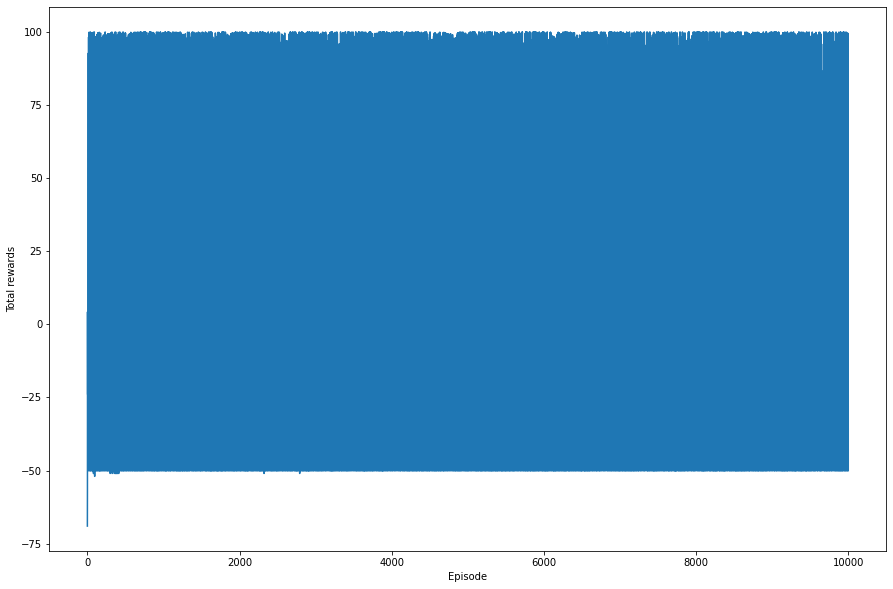

In [10]:
plt.figure(figsize=(15,10))
plt.xlabel("Episode")
plt.ylabel("Total rewards")
plt.plot(reward_list)

In [11]:
def moving_average(data,n):
    len_data=len(data)-n
    res_data=np.zeros(len_data)

    for i in range(len_data):
        res_data[i]=sum(data[i:i+n])/n
    return res_data

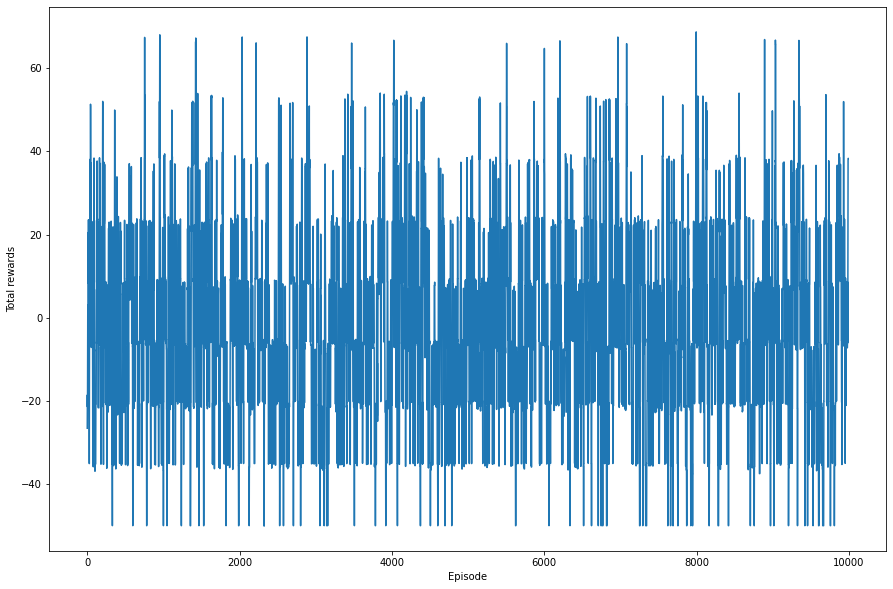

In [12]:
average_number=10
filtered_data=moving_average(reward_list,average_number)
plt.figure(figsize=(15,10))
plt.xlabel("Episode")
plt.ylabel("Total rewards")
plt.plot(filtered_data)

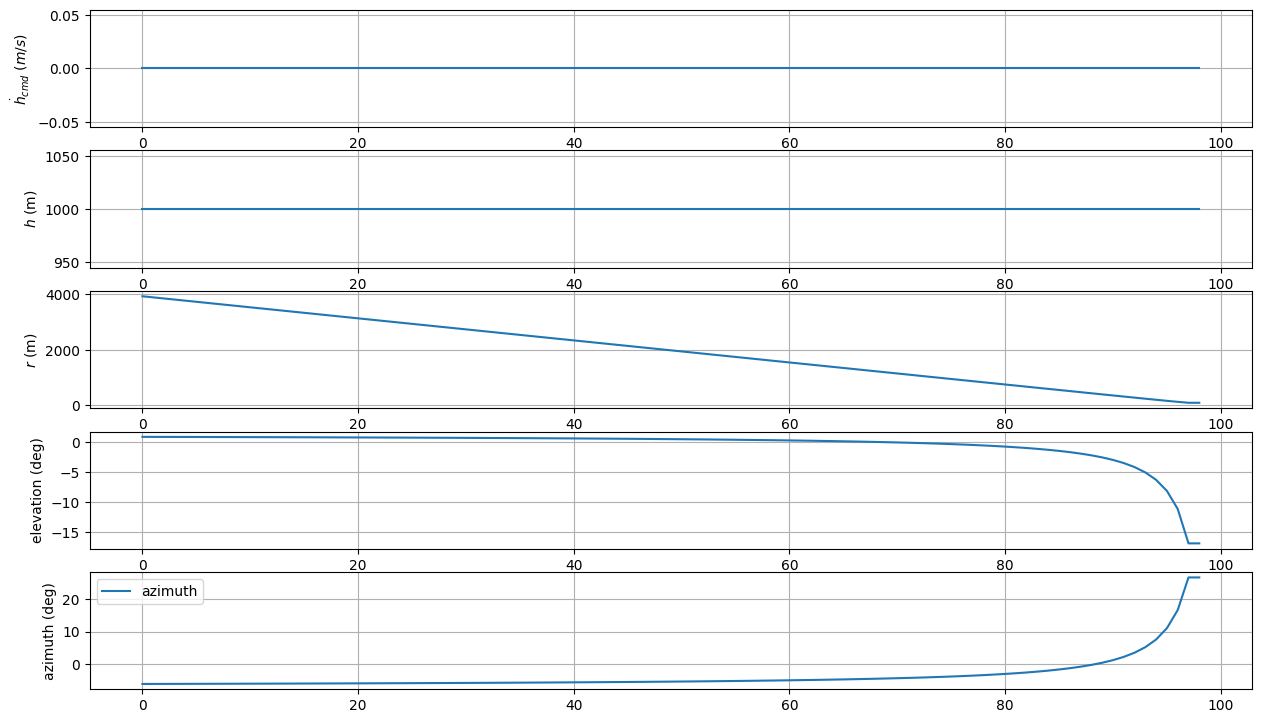

In [13]:
# plots
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

plt_res=total_res[99]


plt.figure(figsize=(15,9), dpi=100)

plt.subplot(511)
plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()

plt.subplot(512)
plt.plot(plt_res[:,10],label=r'$\{h}$')
plt.ylabel(r'$h$ (m)'), plt.grid()

plt.subplot(513)
plt.plot(plt_res[:,1],label=r'$\{r}$')
plt.ylabel(r'$r$ (m)'), plt.grid()

plt.subplot(514)
plt.plot(plt_res[:,2]*Rad2Deg, label='elevation')
plt.ylabel('elevation (deg)'), plt.grid()

plt.subplot(515)
plt.plot(plt_res[:,3]*Rad2Deg, label='azimuth')
plt.ylabel('azimuth (deg)'), plt.grid()

plt.legend()
plt.show()

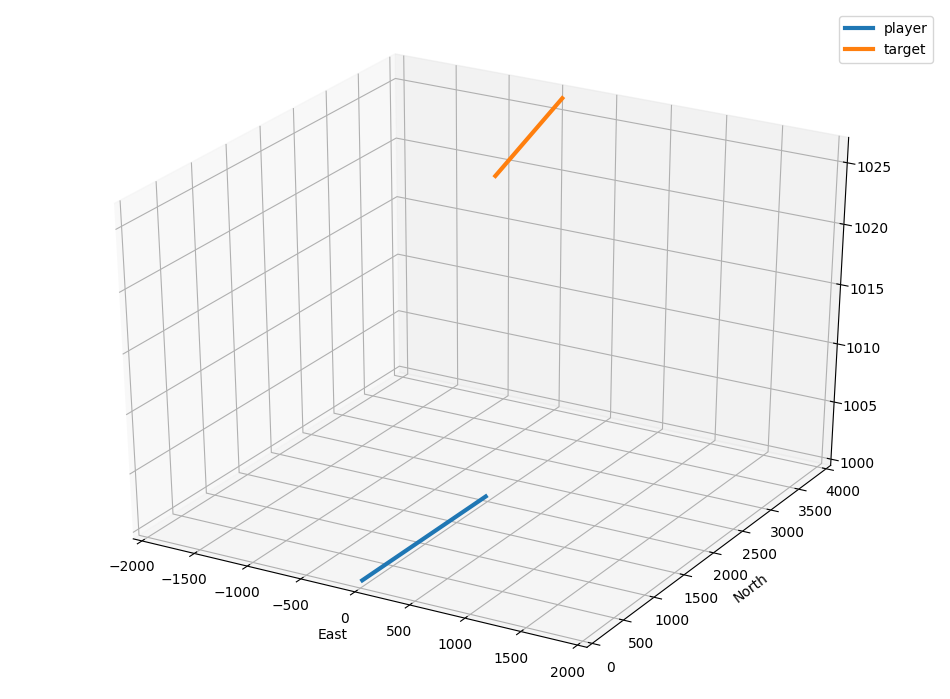

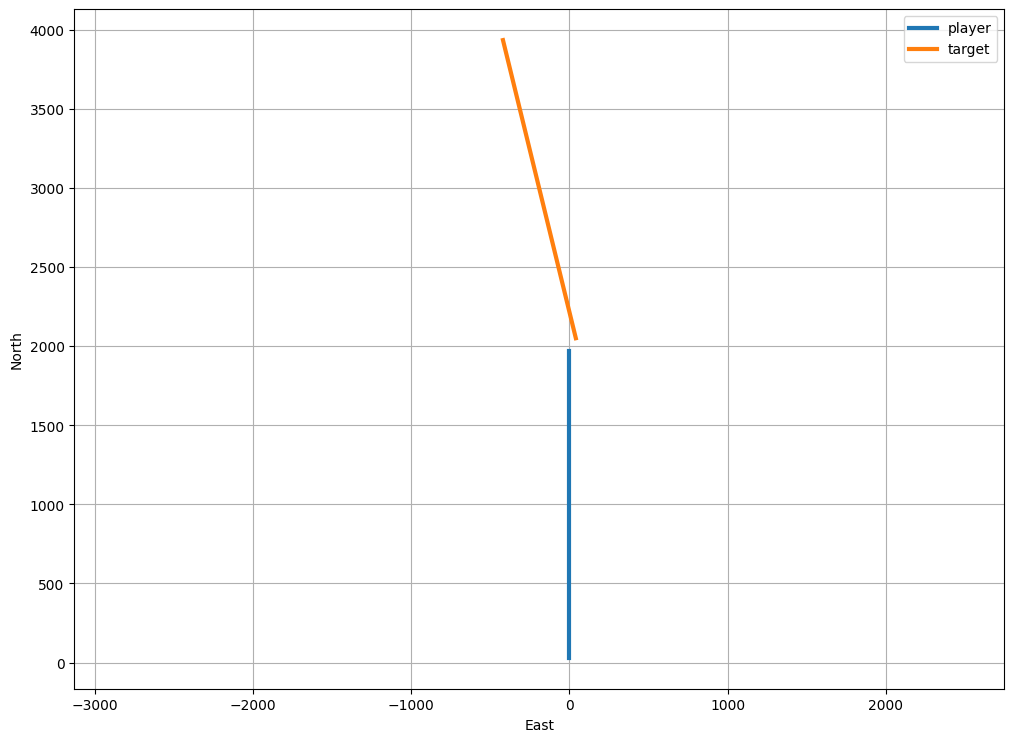

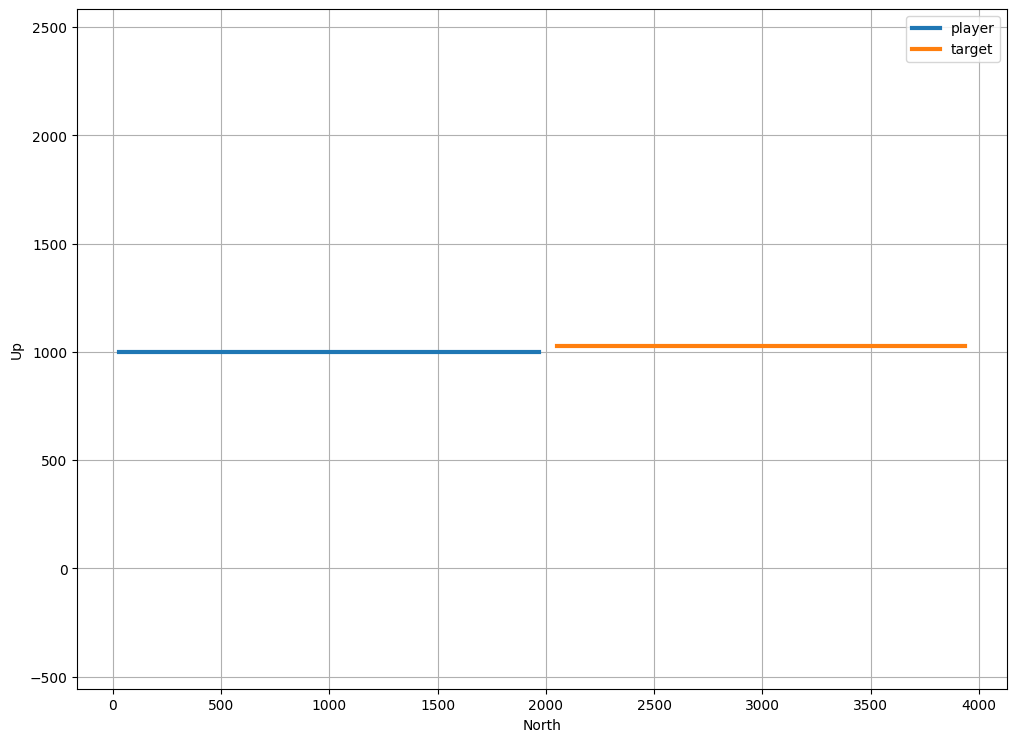

In [14]:
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,9), dpi=100)
plt.gca(projection='3d')
plt.plot(plt_res[:,5], plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.xlim(-2000,2000)
plt.ylim(0,4000)
plt.legend()
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,5], plt_res[:,4], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('North')
plt.ylabel('Up')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

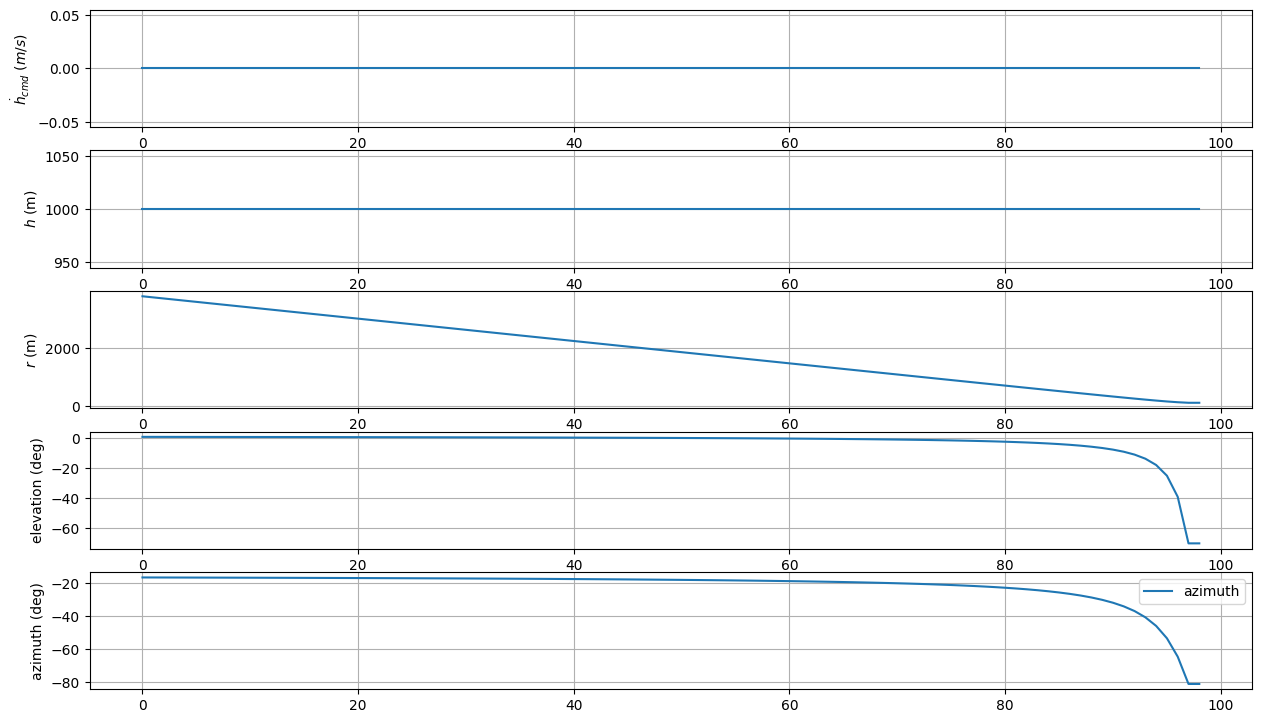

In [19]:
# plots
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

plt_res=total_res[9996]


plt.figure(figsize=(15,9), dpi=100)

plt.subplot(511)
plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()

plt.subplot(512)
plt.plot(plt_res[:,10],label=r'$\{h}$')
plt.ylabel(r'$h$ (m)'), plt.grid()

plt.subplot(513)
plt.plot(plt_res[:,1],label=r'$\{r}$')
plt.ylabel(r'$r$ (m)'), plt.grid()

plt.subplot(514)
plt.plot(plt_res[:,2]*Rad2Deg, label='elevation')
plt.ylabel('elevation (deg)'), plt.grid()

plt.subplot(515)
plt.plot(plt_res[:,3]*Rad2Deg, label='azimuth')
plt.ylabel('azimuth (deg)'), plt.grid()

plt.legend()
plt.show()

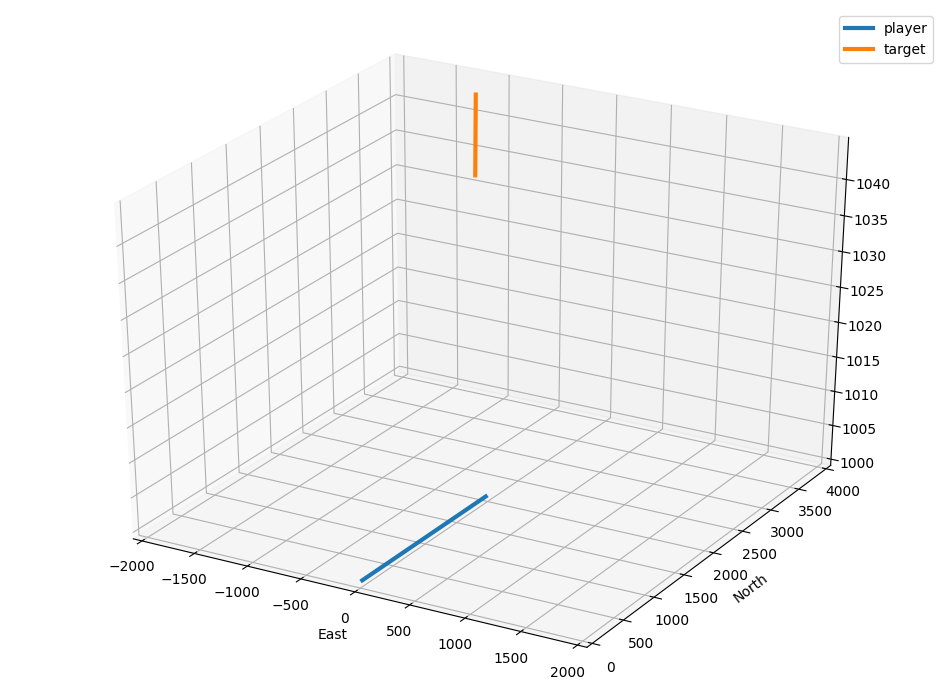

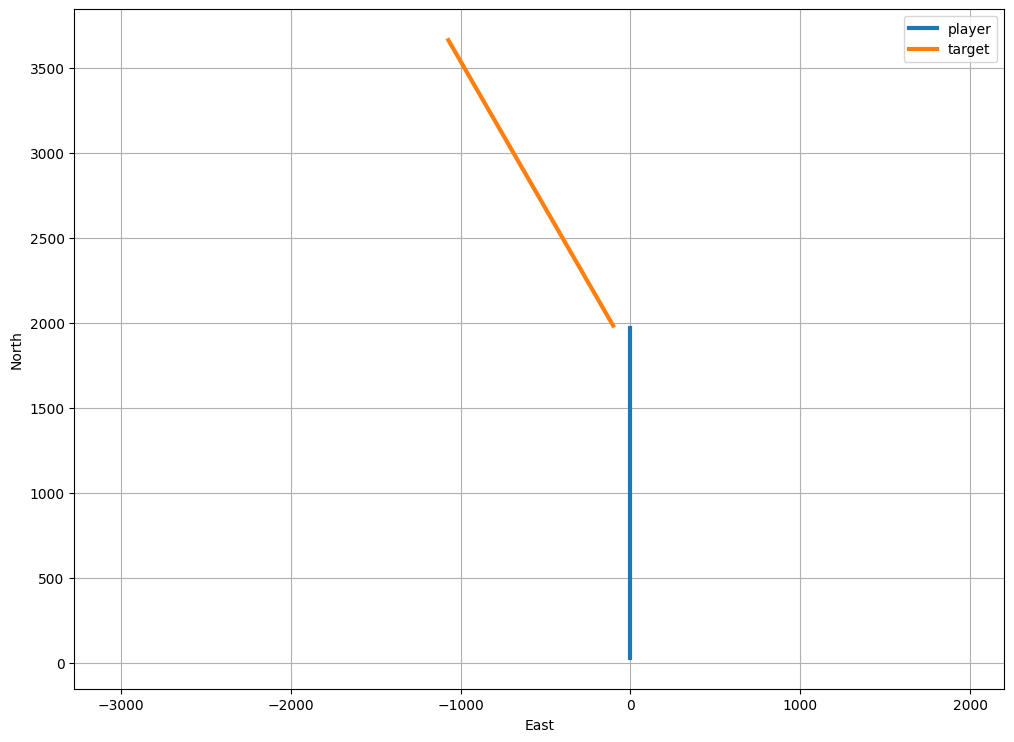

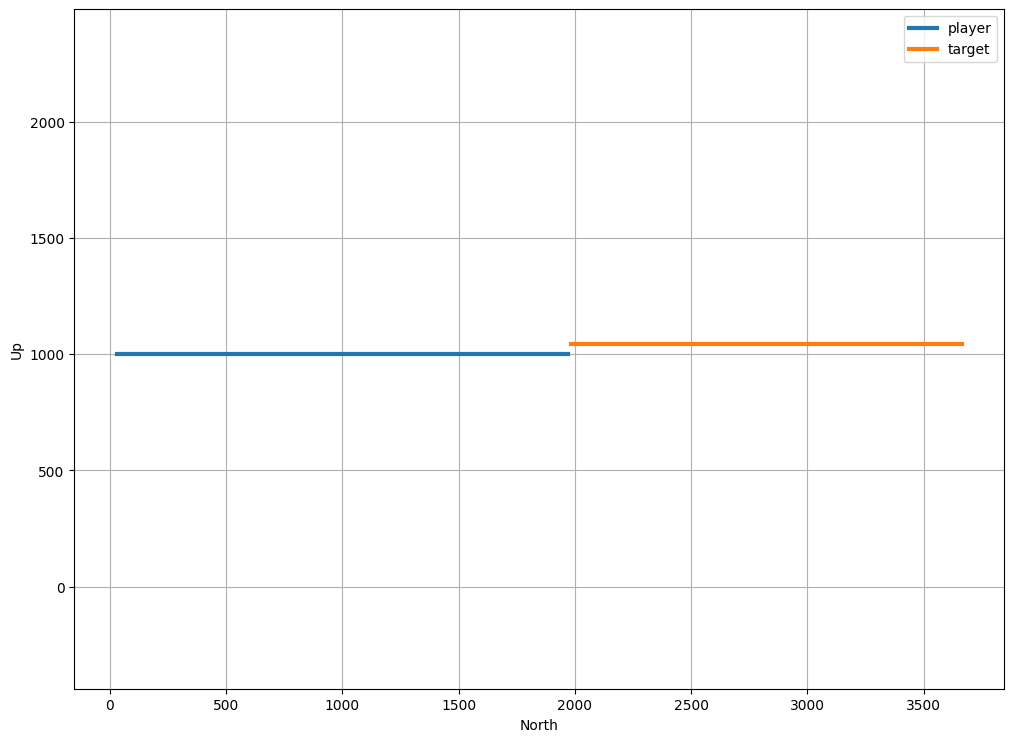

In [20]:
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,9), dpi=100)
plt.gca(projection='3d')
plt.plot(plt_res[:,5], plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.xlim(-2000,2000)
plt.ylim(0,4000)
plt.legend()
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,5], plt_res[:,4], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('North')
plt.ylabel('Up')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

In [21]:
min(plt_res[:,1])

112.17403330605488